<a href="https://colab.research.google.com/github/levina-ai/credit-risk-ml/blob/main/01_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 — Data Cleaning & Exploration (Home Credit)
This notebook prepares the Home Credit application dataset for downstream modeling.

**What I do here:**
- Run quality checks (shape, target imbalance, duplicates).
- Investigate missingness and document an imputation strategy (implemented later **inside pipelines** to avoid leakage).
- Perform outlier diagnostics (univariate IQR + multivariate KNN) and decide how to handle extremes.
- Basic EDA (numeric + categorical) to understand distributions and default-rate patterns.
- Reduce redundancy (highly correlated / overlapping variables) and create engineered features.
- Save a cleaned dataset: `proj_data_clean.csv`.

**Key anti-leakage rule**
Any transformation that can “learn” from the full sample (imputation values, scaling parameters, encodings) is *not fitted here*. I only define decisions/logic and apply safe, rule-based cleaning. Model-time preprocessing is done in Task 2 inside cross-validation pipelines.


Optional audit outputs (if enabled):
- `exact_duplicates.csv`
- `frequencies.txt`



# Task 1 — Data Cleaning and Exploration  


## Project Context
Home Credit is a financial services company that provides loans to customers often underserved by traditional banking institutions. The goal is to use machine learning to assess default risk at the loan application stage, enabling better decision-making and optimized loan offerings.
Understanding which customers are likely to default is crucial for reducing financial losses and improving operational efficiency.


## 1) Setup & Data Load
I load the dataset, run basic checks, and inspect class imbalance.
> If you run this notebook in Google Colab, you may need to install `pyod` first.


In [8]:
!pip -q install pyod

# data
import pandas as pd
import numpy as np
import csv

# plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pandas.plotting import scatter_matrix

# stats / modeling helpers
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# outlier detection
from pyod.models.knn import KNN

proj_data = pd.read_csv(DATA_PATH)
proj_data.index = range(len(proj_data))
proj_data.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,MISSED,RECOVERED
0,330409,0.0,Cash loans,F,Y,Y,0,112500.0,1125000.0,33025.5,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-603.0,0.0,NaN
1,421359,0.0,Revolving loans,M,N,Y,1,162000.0,270000.0,13500.0,...,0.0168,NaN,No,1.0,0.0,1.0,0.0,-933.0,0.0,NaN
2,378826,0.0,Cash loans,F,N,Y,0,157500.0,580500.0,49824.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-211.0,0.0,NaN
3,305942,0.0,Cash loans,F,N,Y,1,121500.0,280170.0,30303.0,...,NaN,NaN,NaN,13.0,0.0,13.0,0.0,-1719.0,0.0,NaN
4,329908,0.0,Revolving loans,M,Y,Y,0,135000.0,135000.0,6750.0,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,-573.0,0.0,NaN


In [9]:
DATA_PATH = "project_data.csv"
OUTPUT_CLEAN_PATH = "proj_data_clean.csv"

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [10]:
SAVE_AUDIT_FILES = True  # set False if you don't want to write audit files

In [11]:
proj_data.shape

(88129, 95)

The dataset contains **158,791 observations** and **95 features** related to loan applications.


In [12]:
proj_data['TARGET'].value_counts(normalize=True)

,proportion
TARGET,
0.0,0.849346
1.0,0.150654


I observe a clear case of **class imbalance**: around **85%** of observations are non-default loans.  
I take this into account later in modeling (e.g., PR-AUC, class weights, threshold tuning).


## 2) Duplicate Checks
I check both exact duplicates and repeated `SK_ID_CURR` values to ensure the dataset represents unique applications.


### 2.1 Exact duplicates


In [13]:
# Look at exactly duplicated rows
exact_duplicates = proj_data[proj_data.duplicated(keep=False)].sort_values("SK_ID_CURR")
if SAVE_AUDIT_FILES:
    exact_duplicates.to_csv("exact_duplicates.csv", index=False)
else:
    pass

# Remove exact duplicates (pure noise)
proj_data = proj_data.drop_duplicates().reset_index(drop=True)


### 2.2 Duplicate `SK_ID_CURR`


In [14]:
# Check if the same loan application appears more than once
duplicates = proj_data["SK_ID_CURR"].duplicated().sum()
print(f"Number of duplicate SK_ID_CURR: {duplicates}")

# Inspect duplicated SK_ID_CURR and identify which columns differ
skid_duplicates = (
    proj_data.loc[proj_data["SK_ID_CURR"].duplicated(keep=False)]
    .sort_values("SK_ID_CURR")
)

rows = []
for sk_id, group in skid_duplicates.groupby("SK_ID_CURR"):
    nunique = group.nunique(dropna=False)
    varying_cols = nunique[nunique > 1].index.tolist()

    rows.append({
        "SK_ID_CURR": sk_id,
        "n_rows": len(group),
        "n_diff_cols": len(varying_cols),
        "diff_cols": varying_cols
    })

diff_df = pd.DataFrame(rows).sort_values(["n_diff_cols", "n_rows"], ascending=False)
diff_df


Number of duplicate SK_ID_CURR: 68


,SK_ID_CURR,n_rows,n_diff_cols,diff_cols
1,111615,2,2,"[MISSED, RECOVERED]"
2,112580,2,2,"[MISSED, RECOVERED]"
3,124012,2,2,"[MISSED, RECOVERED]"
4,125077,2,2,"[MISSED, RECOVERED]"
5,125467,2,2,"[MISSED, RECOVERED]"
...,...,...,...,...
24,235936,2,1,[RECOVERED]
32,269500,2,1,[RECOVERED]
52,384336,2,1,[RECOVERED]
58,411148,2,1,[RECOVERED]


In [15]:
mask = proj_data["SK_ID_CURR"] == 411148
proj_data[mask]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,MISSED,RECOVERED
35674,411148,1.0,Cash loans,F,N,N,0,225000.0,729792.0,37260.0,...,NaN,NaN,NaN,2.0,1.0,2.0,1.0,-130.0,4.0,0.285420
69690,411148,1.0,Cash loans,F,N,N,0,225000.0,729792.0,37260.0,...,NaN,NaN,NaN,2.0,1.0,2.0,1.0,-130.0,4.0,0.221687


The duplicates I inspected differ mainly in **`RECOVERED`** and **`MISSED`**.  
This likely occurs because the same client appears in multiple records: one may reflect a period of missed payments, another a later recovery, and both were recorded in the same table.
Either way, these columns look like they could leak outcome information and should be tested for leakage.


### 2.3 Check whether `RECOVERED` and `MISSED` lead to data leakage


In [16]:
# Correlation to target
corr_target = proj_data.corr(numeric_only=True)["TARGET"].sort_values(ascending=False)
corr_target[["RECOVERED", "MISSED"]]

,TARGET
RECOVERED,NaN
MISSED,0.922306


In [17]:
proj_data["MISSING_RECOVERED"] = proj_data["RECOVERED"].isnull()
proj_data[["MISSING_RECOVERED", "TARGET"]].corr(numeric_only=True)

,MISSING_RECOVERED,TARGET
MISSING_RECOVERED,1.0,-1.0
TARGET,-1.0,1.0


This checks whether the missingness of `RECOVERED` predicts default.  
A correlation close to **−1** with `TARGET` indicates that non-defaults almost always have `RECOVERED = NaN` (no default → nothing to recover), while defaults have non-missing values — **severe information leakage**.


### 2.4 Conclusion


The differences in duplicated `SK_ID_CURR` occur in `RECOVERED` and/or `MISSED`, which leak direct information about `TARGET`.  
Therefore, once those variables are removed, I can safely remove duplicates.


In [18]:
# Drop leakage-prone variables
proj_data.drop(columns=["MISSED", "RECOVERED", "MISSING_RECOVERED"], inplace=True, errors="ignore")

# Drop duplicates
proj_data = proj_data.drop_duplicates().reset_index(drop=True)
duplicates_after = proj_data["SK_ID_CURR"].duplicated().sum()
print(f"Number of duplicate SK_ID_CURR after: {duplicates_after}")


Number of duplicate SK_ID_CURR after: 0


## 3) Missing Values Overview


### 3.1 Missing summary


In [19]:
missing_df = pd.DataFrame({
    "missing_count": proj_data.isnull().sum(),
    "missing_percent": proj_data.isnull().mean() * 100
}).sort_values(by="missing_percent", ascending=False)

missing_df


,missing_count,missing_percent
COMMONAREA_MEDI,61356,70.180496
COMMONAREA_MODE,61355,70.179352
COMMONAREA_AVG,61355,70.179352
NONLIVINGAPARTMENTS_AVG,60946,69.711527
NONLIVINGAPARTMENTS_MODE,60946,69.711527
...,...,...
REG_CITY_NOT_LIVE_CITY,0,0.000000
CNT_FAM_MEMBERS,0,0.000000
REGION_RATING_CLIENT,0,0.000000
REGION_RATING_CLIENT_W_CITY,0,0.000000


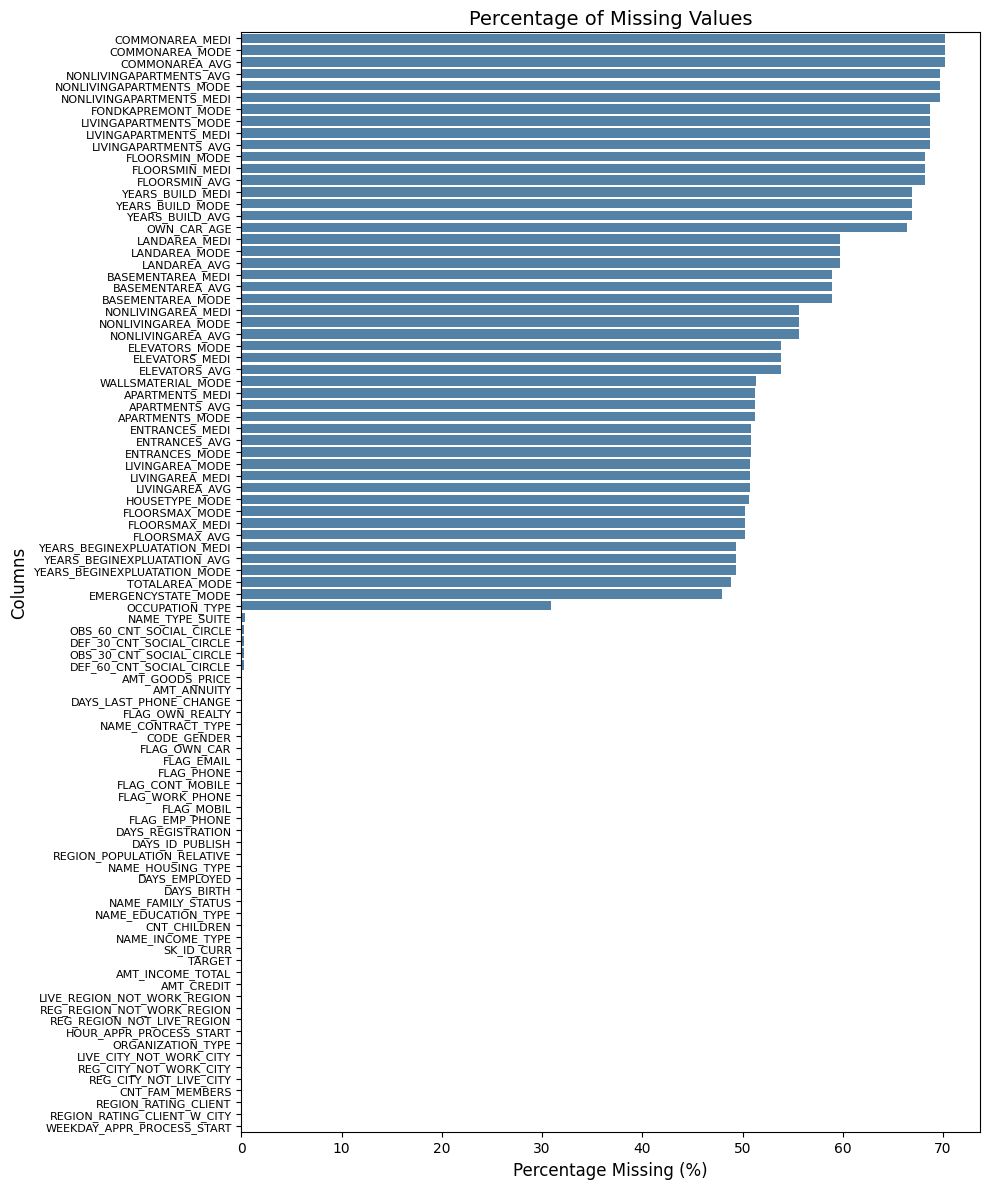

In [20]:
plt.figure(figsize=(10, 12))
sns.barplot(
    x=missing_df["missing_percent"],
    y=missing_df.index,
    color="steelblue"
)
plt.title("Percentage of Missing Values", fontsize=14)
plt.xlabel("Percentage Missing (%)", fontsize=12)
plt.ylabel("Columns", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


Overall, I observe many features with missingness above **50%**. These features either need to be discarded, or their missing values must be imputed before training any model.
The variables with the highest missingness are mostly related to **housing characteristics**, plus `OWN_CAR_AGE` and `OCCUPATION_TYPE`.


In [21]:
# Missingness by row
missing_flags = proj_data.isnull().astype(int)
missing_per_row = missing_flags.sum(axis=1)

pct_no_missing = (missing_per_row == 0).mean()
print(f"Percentage of rows with no missings: {pct_no_missing:.2%}")
print("Number of rows with over 50% missings:", (missing_per_row > missing_flags.shape[1] * 0.5).sum())

# Inspect rows with most missing values
worst_idx = missing_per_row.sort_values(ascending=False).head(10).index
proj_data.loc[worst_idx, :].T


Percentage of rows with no missings: 6.20%
Number of rows with over 50% missings: 42465


,13664,59113,38963,71321,50267,22856,84698,54916,84459,39833
SK_ID_CURR,456135,261700,239253,235599,408344,118278,265145,438505,209500,345725
TARGET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
NAME_CONTRACT_TYPE,Revolving loans,Revolving loans,Revolving loans,Revolving loans,Revolving loans,Revolving loans,Revolving loans,Revolving loans,Revolving loans,Revolving loans
CODE_GENDER,F,F,F,M,F,F,F,M,F,M
FLAG_OWN_CAR,N,N,N,N,N,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...
OBS_30_CNT_SOCIAL_CIRCLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEF_30_CNT_SOCIAL_CIRCLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OBS_60_CNT_SOCIAL_CIRCLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEF_60_CNT_SOCIAL_CIRCLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
suffixes = ("_AVG", "_MEDI", "_MODE")
proj_no_house = proj_data.loc[:, ~proj_data.columns.str.endswith(suffixes)]

missing_flags_no_house = proj_no_house.isnull().astype(int)
missing_per_row_no_house = missing_flags_no_house.sum(axis=1)

print("Number of rows with over 50% missings (excluding housing suffix vars):",
      (missing_per_row_no_house > proj_no_house.shape[1] * 0.5).sum())


Number of rows with over 50% missings (excluding housing suffix vars): 0


It does not make sense to remove rows with over 50% missing values, because this missingness is largely driven by **apartment/house characteristics**.  
If those variables are excluded, the issue of rows with more than 50% missing values largely disappears.


### 3.2 Check whether missingness is predictive


In [23]:
missing_flags = proj_data.isnull().astype(int).add_prefix("MISSING_")
corr_with_target = (
    missing_flags.join(proj_data["TARGET"])
    .corr(numeric_only=True)["TARGET"]
    .abs()
    .sort_values(ascending=False)
)
corr_with_target = pd.DataFrame(corr_with_target).dropna()
corr_with_target.head(30)


,TARGET
TARGET,1.000000
MISSING_TOTALAREA_MODE,0.051034
MISSING_EMERGENCYSTATE_MODE,0.050837
MISSING_ELEVATORS_MEDI,0.050677
MISSING_ELEVATORS_MODE,0.050677
MISSING_ELEVATORS_AVG,0.050677
MISSING_FLOORSMAX_AVG,0.050361
MISSING_FLOORSMAX_MEDI,0.050351
MISSING_FLOORSMAX_MODE,0.050351
MISSING_YEARS_BEGINEXPLUATATION_MODE,0.050202


The correlations between missingness flags and `TARGET` are very small (mostly around **0.00–0.05**).  
This suggests missingness does not strongly predict the target overall, making imputation a reasonable approach.
Important: I avoid leakage by doing imputation **only inside pipelines** in Task 2 (fit on train folds only), not on the full dataset.


### 3.3 Check missing values of housing characteristics


In [24]:
realty_columns = [c for c in proj_data.columns if c.endswith(("_MODE", "_AVG", "_MEDI"))]

housing_nonmissing_count = proj_data[realty_columns].notna().sum(axis=1)
housing_any_info = housing_nonmissing_count > 0
housing_all_missing = housing_nonmissing_count == 0

realty_flag = proj_data["FLAG_OWN_REALTY"]  # Y/N

p_owner_given_all_missing = (realty_flag[housing_all_missing] == "Y").mean()
p_owner_given_any_info = (realty_flag[housing_any_info] == "Y").mean()
p_nonowner_given_all_missing = (realty_flag[housing_all_missing] == "N").mean()

print("P(OWN_REALTY=Y | ALL housing vars missing):", p_owner_given_all_missing)
print("P(OWN_REALTY=Y | ANY housing info exists):", p_owner_given_any_info)
print("P(OWN_REALTY=N | ALL housing vars missing):", p_nonowner_given_all_missing)


P(OWN_REALTY=Y | ALL housing vars missing): 0.6793712881913803
P(OWN_REALTY=Y | ANY housing info exists): 0.7041033868876239
P(OWN_REALTY=N | ALL housing vars missing): 0.32062871180861974


The hypothesis “missing housing variables implies the applicant does not own realty” is **not supported**, since `P(OWN_REALTY=Y | ALL missing)` is not close to 0.


### 3.4 Check missing values of `OWN_CAR_AGE`


Hypothesis: missing `OWN_CAR_AGE` implies the applicant does not own a car.


In [25]:
pd.crosstab(
    proj_data["FLAG_OWN_CAR"],
    proj_data["OWN_CAR_AGE"].isna(),
    normalize="index"
)


OWN_CAR_AGE,False,True
FLAG_OWN_CAR,,
N,0.000000,1.000000
Y,0.999966,0.000034


Missing car age is indeed strongly related to not owning a car.


### 3.5 Check missing values of `OCCUPATION_TYPE`


Hypothesis: missing `OCCUPATION_TYPE` implies the applicant is unemployed or retired.


In [26]:
# Fill missing categoricals for consistency with dataset conventions
cat_vars = proj_data.select_dtypes(include="object").columns
proj_data[cat_vars] = proj_data[cat_vars].fillna("XNA")

mask = proj_data["OCCUPATION_TYPE"] == "XNA"
occ_missing = proj_data[mask]

pd.crosstab(
    occ_missing["NAME_INCOME_TYPE"],
    columns="count",
    normalize=True
).sort_values(by="count", ascending=False)


col_0,count
NAME_INCOME_TYPE,
Pensioner,0.566568
Working,0.263532
Commercial associate,0.131174
State servant,0.038430
Unemployed,0.000222
Student,0.000074


This hypothesis is not fully supported: observations are missing even for working applicants.


### 3.6 Conclusions on missingness


To avoid leakage, I impute missing values only during modeling, inside cross-validation pipelines.
- For `OWN_CAR_AGE`: I plan to impute the median car age among applicants who own a car, and set it to 0 for non-owners.
- For categorical features: I keep missing values as an explicit category (`XNA`/`Missing`).
- For other numeric variables: since missingness appears weakly related to the target, I plan to use median imputation inside pipelines.


## 4) Outlier Analysis


### 4.1 Select key variables
I focus on numeric variables such as:
- financial variables (loan amounts and income)
- demographic-related variables
- count variables (household size and social-circle indicators)


In [27]:
proj_data["AGE"] = -proj_data["DAYS_BIRTH"] / 365
proj_data["YEARS_EMPLOYED"] = -proj_data["DAYS_EMPLOYED"] / 365
proj_data["DAYS_REGISTRATION"] = -proj_data["DAYS_REGISTRATION"] / 365
proj_data["DAYS_ID_PUBLISH"] = -proj_data["DAYS_ID_PUBLISH"] / 365

financial_vars = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]

demo_vars = [
    "AGE",
    "YEARS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "DAYS_LAST_PHONE_CHANGE",
    "OWN_CAR_AGE",
]

count_vars = [
    "CNT_CHILDREN",
    "CNT_FAM_MEMBERS",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
]

outlier_vars = financial_vars + demo_vars + count_vars


### 4.2 Univariate analysis (IQR rule)


I identify outliers using the interquartile range (IQR) method. For each variable, values below

[ Q1 - 1.5 ⋅ IQR ]
or above
[ Q3 + 1.5 ⋅ IQR ]
are flagged as outliers.

I then compute the proportion of outliers per variable.


In [28]:
outlier_summary = []

for col in outlier_vars:
    q1 = proj_data[col].quantile(0.25)
    q3 = proj_data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outlier_pct = ((proj_data[col] < lower) | (proj_data[col] > upper)).mean() * 100

    outlier_summary.append({
        "variable": col,
        "outlier_percentage": outlier_pct
    })

outlier_df = (
    pd.DataFrame(outlier_summary)
      .sort_values("outlier_percentage", ascending=False)
)
outlier_df


,variable,outlier_percentage
5,YEARS_EMPLOYED,23.088097
13,DEF_30_CNT_SOCIAL_CIRCLE,11.735639
15,DEF_60_CNT_SOCIAL_CIRCLE,8.568389
12,OBS_30_CNT_SOCIAL_CIRCLE,6.602155
14,OBS_60_CNT_SOCIAL_CIRCLE,6.452314
3,AMT_GOODS_PRICE,4.554709
0,AMT_INCOME_TOTAL,4.529545
2,AMT_ANNUITY,2.339121
1,AMT_CREDIT,2.058884
9,OWN_CAR_AGE,1.581909


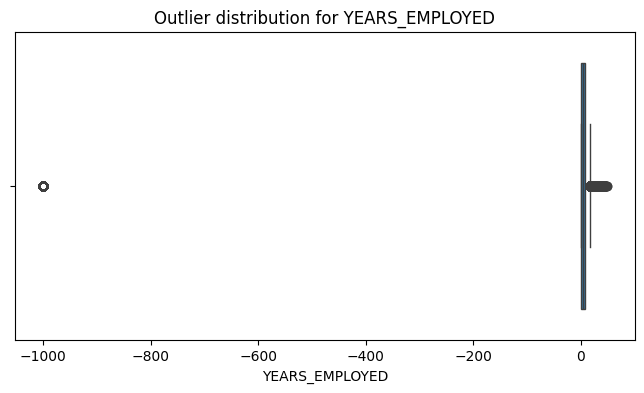

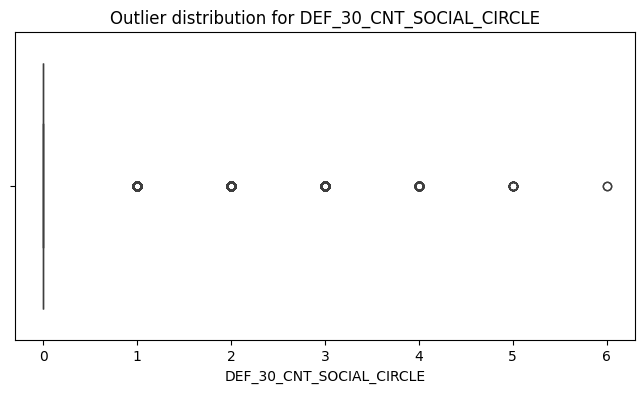

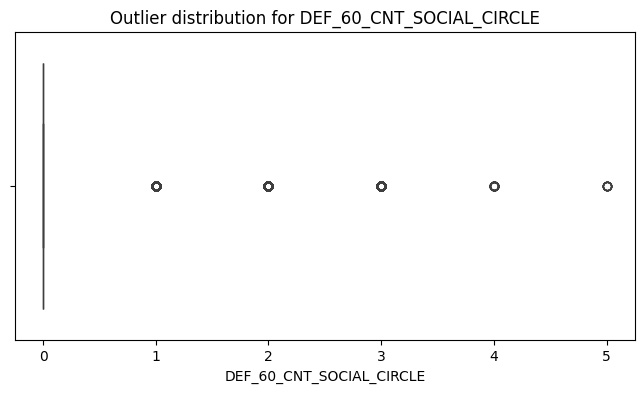

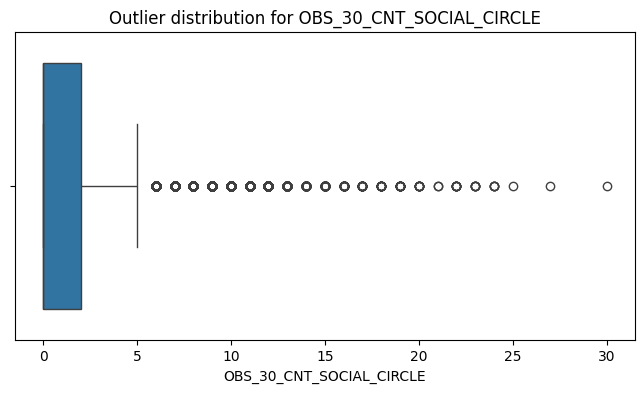

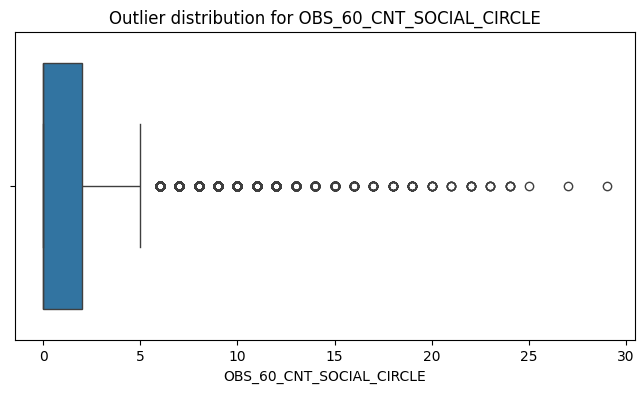

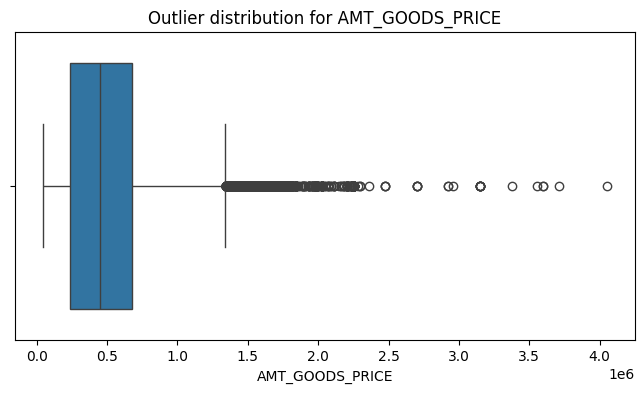

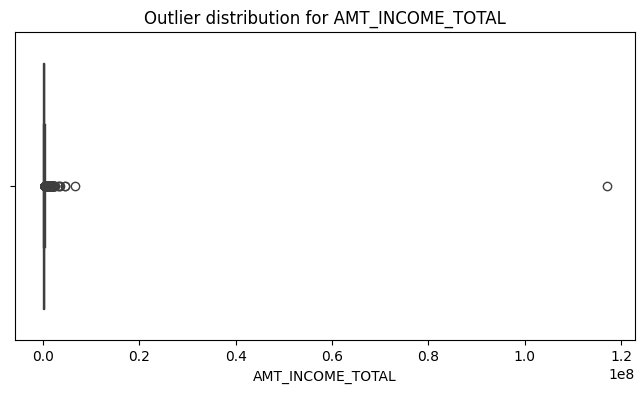

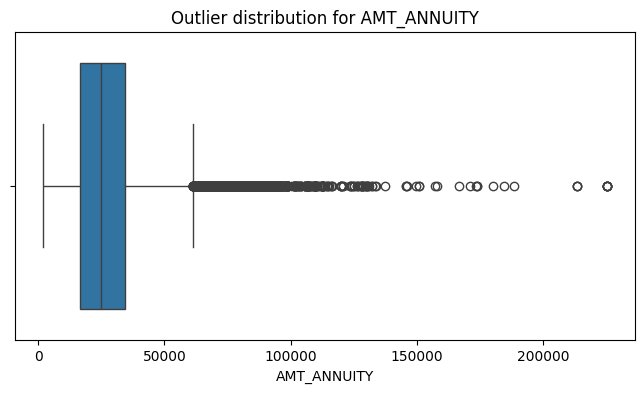

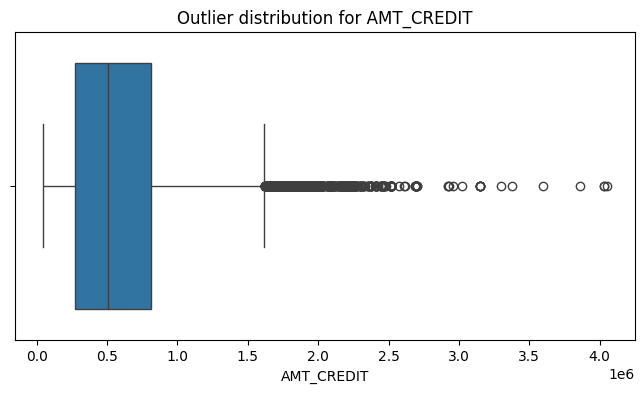

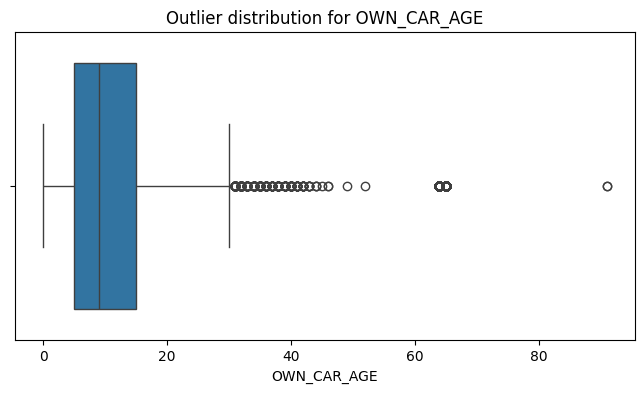

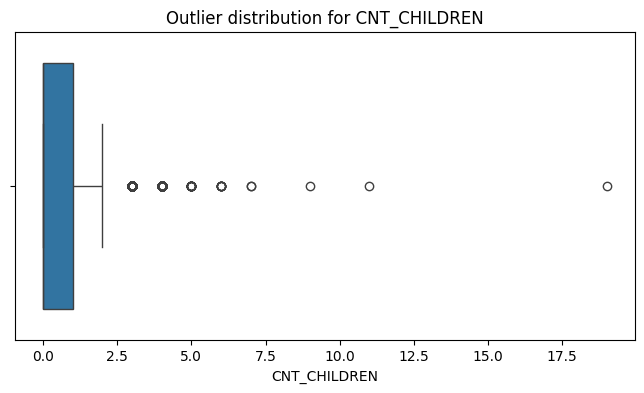

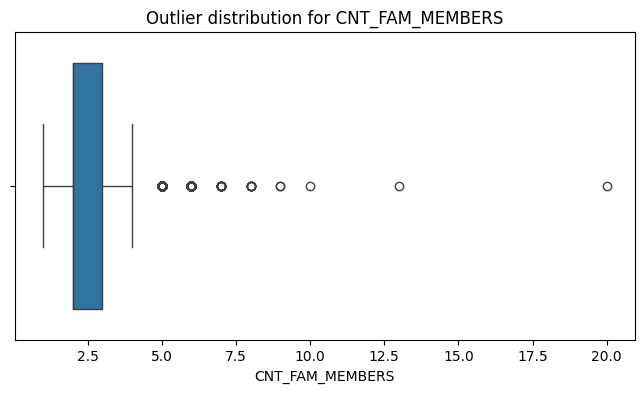

In [29]:
top_outliers = outlier_df[outlier_df["outlier_percentage"] > 1]["variable"]

for col in top_outliers:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=proj_data[col])
    plt.title(f"Outlier distribution for {col}")
    plt.show()


Boxplots of variables with more than 1% IQR-based extreme values suggest:
- Social-circle variables have a large mass at zero, so IQR flags many valid observations as “outliers”.
- Financial variables are heavy-tailed; these values could be economically meaningful.
- Household variables show mostly small families; a few large families are flagged but can still be plausible.


#### 4.2.1 Q–Q plots for monetary variables


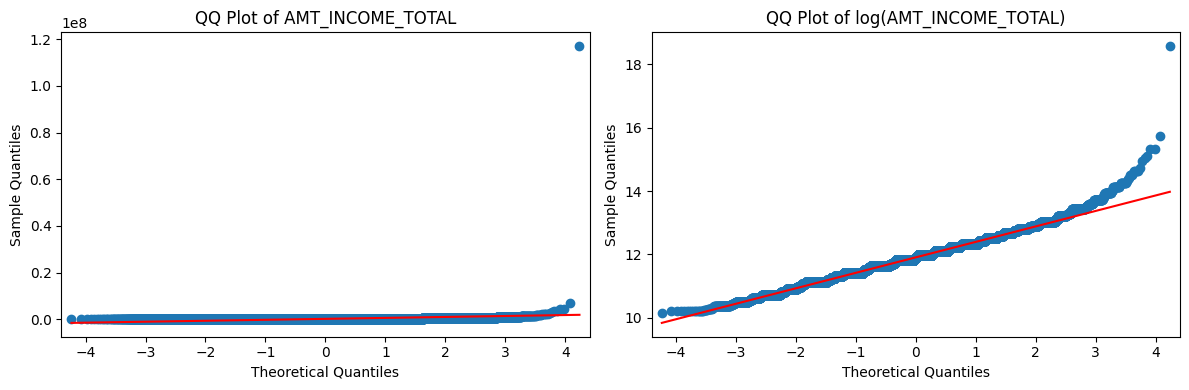

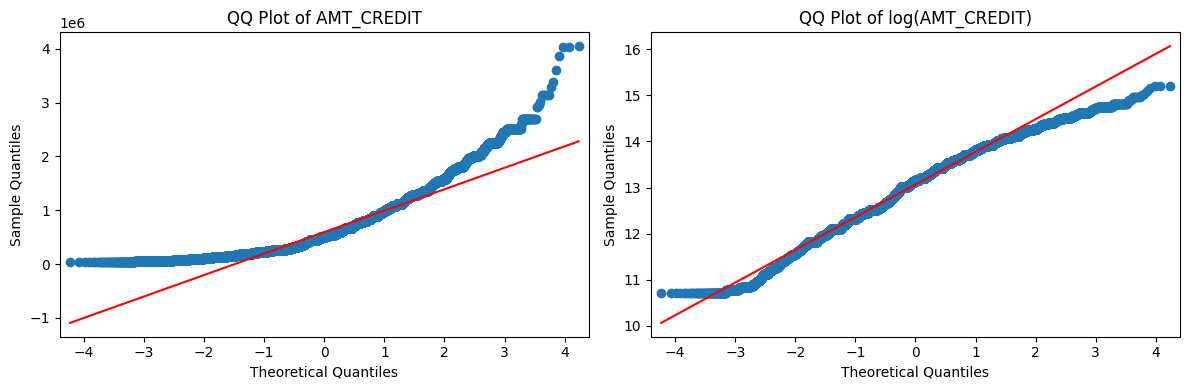

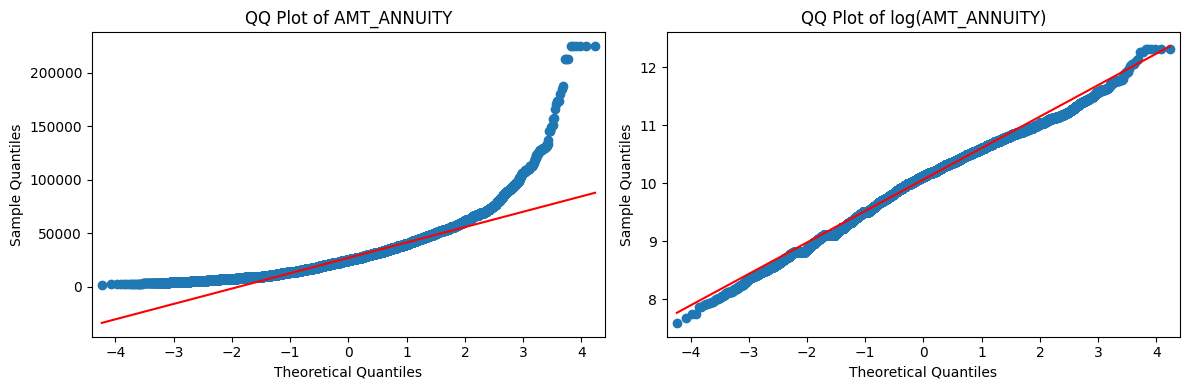

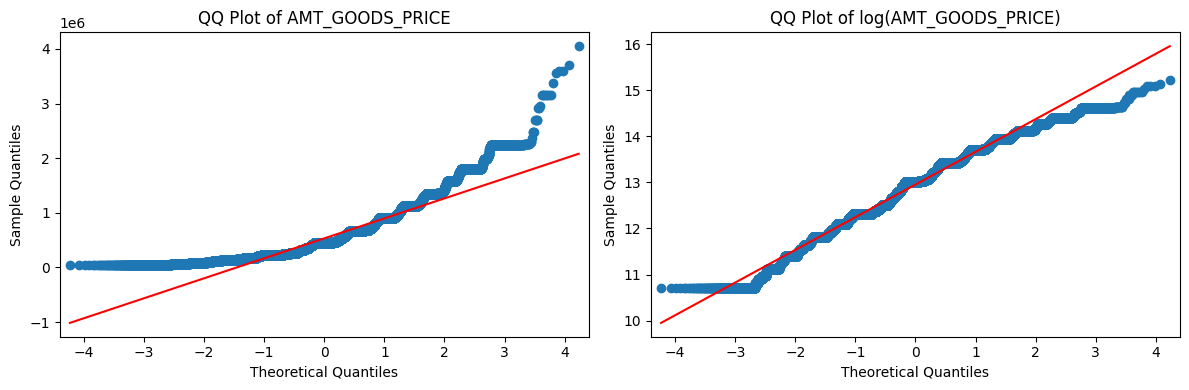

In [30]:
for col in financial_vars:
    data = proj_data[col].dropna()
    log_data = np.log(data[data > 0])

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sm.qqplot(data, line="s", ax=axes[0])
    axes[0].set_title(f"QQ Plot of {col}")

    sm.qqplot(log_data, line="s", ax=axes[1])
    axes[1].set_title(f"QQ Plot of log({col})")

    plt.tight_layout()
    plt.show()


The raw `AMT_INCOME_TOTAL` distribution is dominated by extreme right-tail values, which distort the scale of Q–Q plots. A log transform improves interpretability; however, a very extreme upper-tail observation remains.
The other monetary variables are also right-skewed. After log transformation they exhibit near-linear behavior, indicating approximate log-normality with mild tail deviations.


#### 4.2.2 Are extreme values in `AMT_INCOME_TOTAL` meaningful?


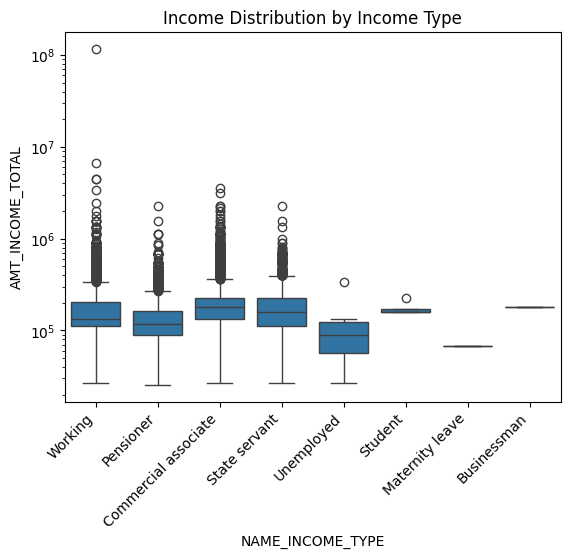

In [31]:
sns.boxplot(
    x="NAME_INCOME_TYPE",
    y="AMT_INCOME_TOTAL",
    data=proj_data
)
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.title("Income Distribution by Income Type")
plt.show()


Values that appear as outliers belong to income groups that are economically plausible.


#### 4.2.3 Inspect extreme income values


In [32]:
proj_data["AMT_INCOME_TOTAL"].describe(percentiles=[.99, .995, .999])

mask = proj_data["AMT_INCOME_TOTAL"] > 4_500_000.0
proj_data[mask].T


,231,52112
SK_ID_CURR,252084,114967
TARGET,0.0,1.0
NAME_CONTRACT_TYPE,Cash loans,Cash loans
CODE_GENDER,M,F
FLAG_OWN_CAR,Y,N
...,...,...
OBS_60_CNT_SOCIAL_CIRCLE,0.0,0.0
DEF_60_CNT_SOCIAL_CIRCLE,0.0,0.0
DAYS_LAST_PHONE_CHANGE,-695.0,0.0
AGE,52.989041,34.561644


The first few IDs appear unusual (high income but low `YEARS_EMPLOYED`).  
However, this is not enough evidence to conclude data errors; these may still be genuine rare cases.


### 4.3 Multivariate outliers (KNN)


To further assess outliers, I run a multivariate KNN outlier detector on a small set of key demographic and financial variables.
A multivariate outlier is a point that deviates significantly from expected behavior when multiple variables are considered simultaneously.


In [33]:
analysis_vars = [
    "AGE",
    "YEARS_EMPLOYED",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "CNT_FAM_MEMBERS",
]

X = proj_data[analysis_vars].dropna()

# Standardize variables so they contribute equally to distance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = KNN(contamination=0.05)
knn.fit(X_scaled)

proj_data.loc[X.index, "MULTIVAR_OUTLIER"] = knn.labels_
proj_data.loc[X.index, "OUTLIER_SCORE"] = knn.decision_scores_

proj_data["MULTIVAR_OUTLIER"].value_counts()


,count
MULTIVAR_OUTLIER,
0.0,83051
1.0,4372


In [34]:
proj_data.loc[proj_data["MULTIVAR_OUTLIER"] == 1,
              analysis_vars + ["OUTLIER_SCORE"]].sort_values("OUTLIER_SCORE", ascending=False).head(10)


,AGE,YEARS_EMPLOYED,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,OUTLIER_SCORE
52112,34.561644,2.526027,117000000.0,562491.0,26194.5,3.0,278.300341
79699,28.210959,2.454795,112500.0,135000.0,8788.5,20.0,13.116413
231,52.989041,1.213699,6750000.0,790830.0,52978.5,2.0,11.098620
13984,29.528767,1.035616,4500000.0,2250000.0,225000.0,1.0,8.970974
35189,36.673973,15.243836,3150000.0,2250000.0,225000.0,2.0,5.889462
66636,50.578082,23.210959,4500000.0,450000.0,47749.5,1.0,5.698051
11993,47.419178,0.542466,315000.0,1007761.5,38515.5,13.0,5.550928
31236,35.838356,-1000.665753,2250000.0,2250000.0,112500.0,1.0,4.799708
53559,34.169863,4.712329,1575000.0,3299688.0,170986.5,3.0,4.231387
15224,27.364384,2.369863,3600000.0,953460.0,68791.5,2.0,4.090108


The detector flags cases with unusually large `AMT_INCOME_TOTAL` and `AMT_CREDIT` relative to `YEARS_EMPLOYED`, as well as relatively young applicants.
**Modeling implication:** I do not automatically drop these observations. Instead, I handle them through robust preprocessing (e.g., log transforms for monetary variables and scaling).


## 5) Numerical Variables — EDA


In [35]:
proj_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,87426.0,278146.563288,102696.479590,100003.000000,189151.250000,278002.000000,366721.750000,4.562540e+05
TARGET,87426.0,0.151088,0.358136,0.000000,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,87426.0,0.423215,0.727349,0.000000,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,87426.0,169358.397561,408284.368200,25650.000000,112500.000000,144000.000000,202500.000000,1.170000e+08
AMT_CREDIT,87426.0,594286.255456,398504.952571,45000.000000,270000.000000,509922.000000,808650.000000,4.050000e+06
...,...,...,...,...,...,...,...,...
DAYS_LAST_PHONE_CHANGE,87425.0,-953.280595,824.596001,-4173.000000,-1557.000000,-744.000000,-269.000000,0.000000e+00
AGE,87426.0,43.666547,11.947428,21.021918,33.712329,42.821918,53.621918,6.904110e+01
YEARS_EMPLOYED,87426.0,-169.913107,382.775162,-1000.665753,0.813699,3.268493,7.438356,4.807123e+01
MULTIVAR_OUTLIER,87423.0,0.050010,0.217966,0.000000,0.000000,0.000000,0.000000,1.000000e+00


Things that stand out:
- `DAYS_EMPLOYED` contains a known placeholder value (e.g., **365243**) inconsistent with “days before application” and must be recoded.
- Monetary variables have wide ranges and strong right skew → likely benefit from log transforms in modeling.
- `OWN_CAR_AGE` has a maximum of 91, which may be unrealistic but could still reflect rare cases.


### 5.1 Check positive values of `DAYS_EMPLOYED`


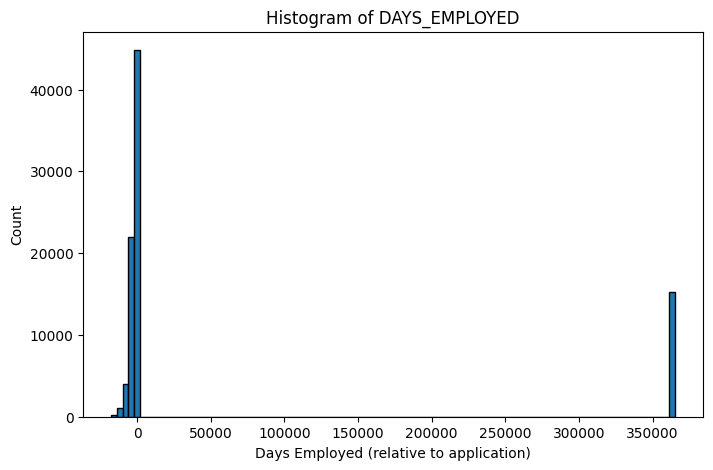

In [36]:
plt.figure(figsize=(8, 5))
plt.hist(proj_data["DAYS_EMPLOYED"].dropna(), bins=100, edgecolor="black")
plt.title("Histogram of DAYS_EMPLOYED")
plt.xlabel("Days Employed (relative to application)")
plt.ylabel("Count")
plt.show()


`DAYS_EMPLOYED` contains clear outliers: values around **365,243 days** (~1000 years), which are impossible.  
These are most likely placeholder values indicating missing/non-applicable employment.
Since the variable represents days **before** the loan application, valid values should be **negative**, so these positives must be cleaned / recoded.


In [37]:
# Check unique positive values of DAYS_EMPLOYED
proj_data.loc[proj_data["DAYS_EMPLOYED"] > 0, "DAYS_EMPLOYED"].unique()

# Check if 365243 aligns with specific income types
proj_data[proj_data["DAYS_EMPLOYED"] > 0].groupby("NAME_INCOME_TYPE")["DAYS_EMPLOYED"].count()


,DAYS_EMPLOYED
NAME_INCOME_TYPE,
Pensioner,15301
Unemployed,6


It is clear that the value **365243** in `DAYS_EMPLOYED` is a placeholder for missing employment.  
This value is mainly observed for **Pensioners** and **Unemployed** applicants.


### 5.2 Correct `DAYS_EMPLOYED`


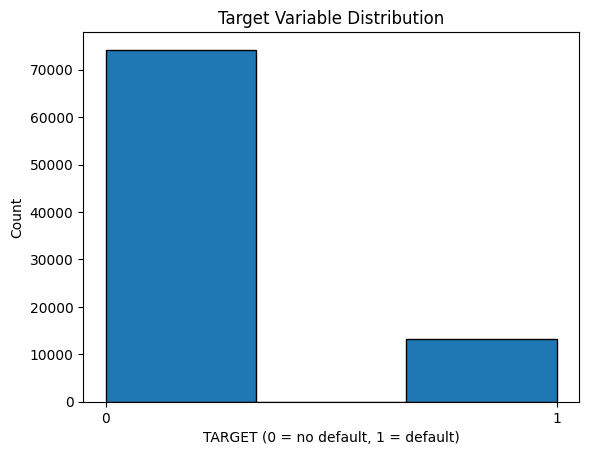

,count
TARGET,
0.0,74217
1.0,13209


In [38]:
proj_data["DAYS_EMPLOYED_ANOMALY"] = proj_data["DAYS_EMPLOYED"] > 0
proj_data.loc[proj_data["DAYS_EMPLOYED"] > 0, "DAYS_EMPLOYED"] = np.nan

plt.hist(proj_data["TARGET"], bins=3, edgecolor="black")
plt.xticks([0, 1])
plt.title("Target Variable Distribution")
plt.xlabel("TARGET (0 = no default, 1 = default)")
plt.ylabel("Count")
plt.show()

proj_data["TARGET"].value_counts()


### 5.3 Universal plot function


In [39]:
def plot_distribution(feature, separate_target=True):
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    plt.title(f"Distribution of {feature}")

    if not separate_target:
        sns.kdeplot(data=proj_data, x=feature, fill=True)
    else:
        sns.kdeplot(data=proj_data[proj_data.TARGET == 0], x=feature, label="Repaid")
        sns.kdeplot(data=proj_data[proj_data.TARGET == 1], x=feature, label="Default")
        plt.legend()
    plt.show()


### 5.4 Numerical analysis


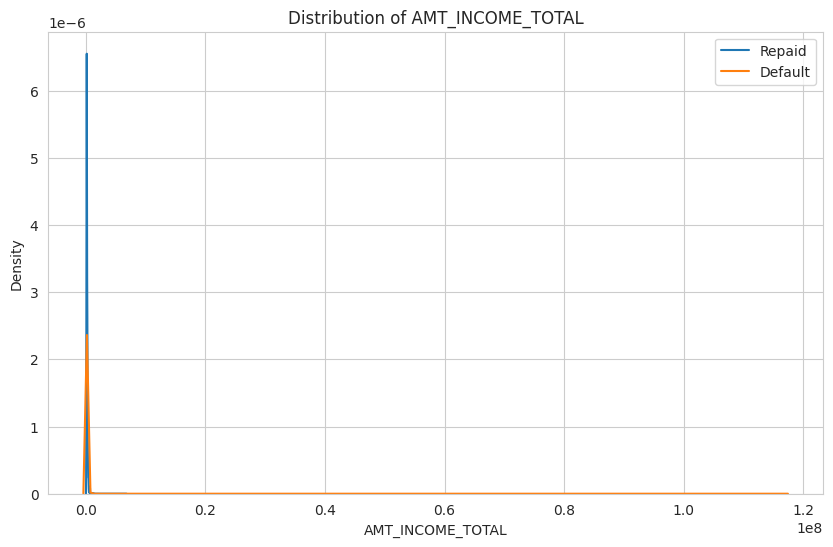

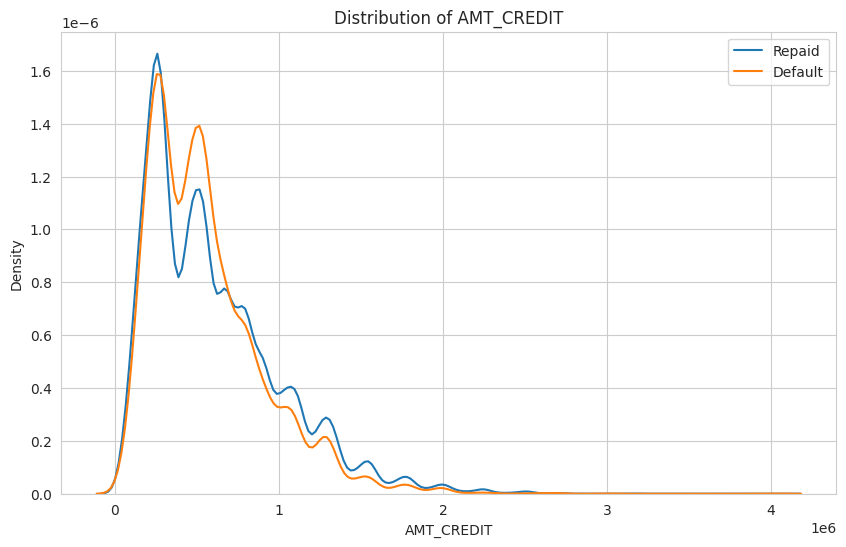

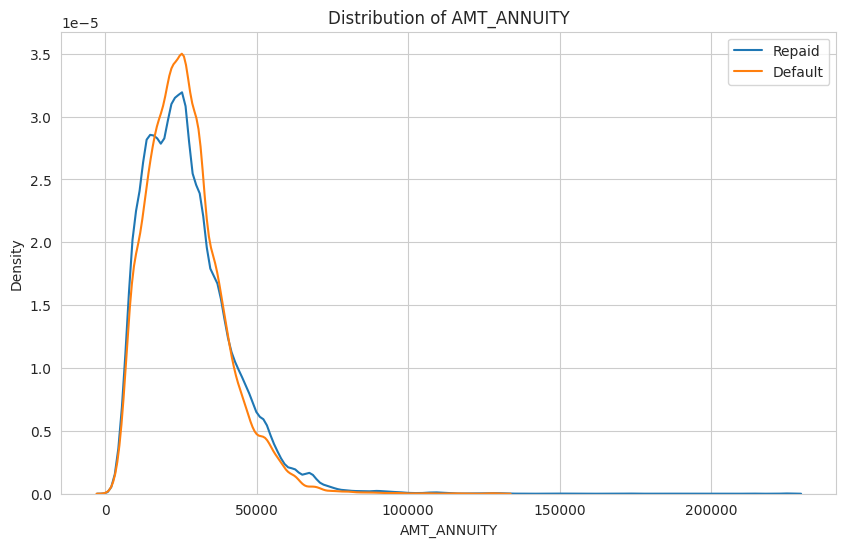

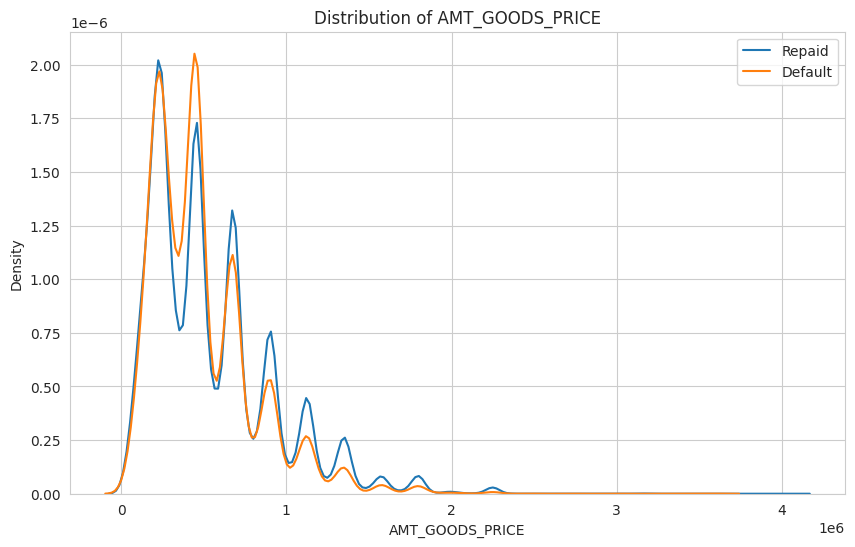

In [40]:
monetary_vars = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]
for v in monetary_vars:
    plot_distribution(v)


Across all monetary/loan size variables, I observe strong right skew and long right tails.
The distributions for repaid and default loans overlap heavily, indicating weak standalone discriminatory power.  
Defaults appear slightly more concentrated at lower `AMT_ANNUITY`.


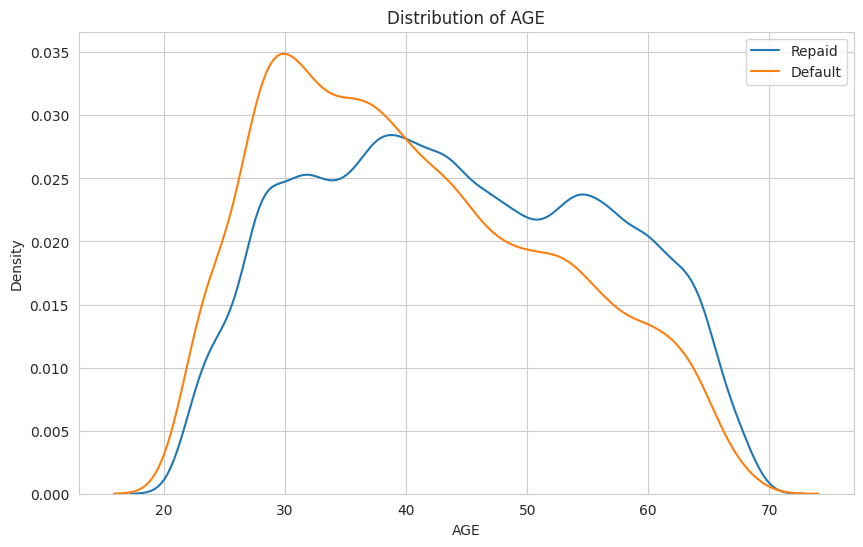

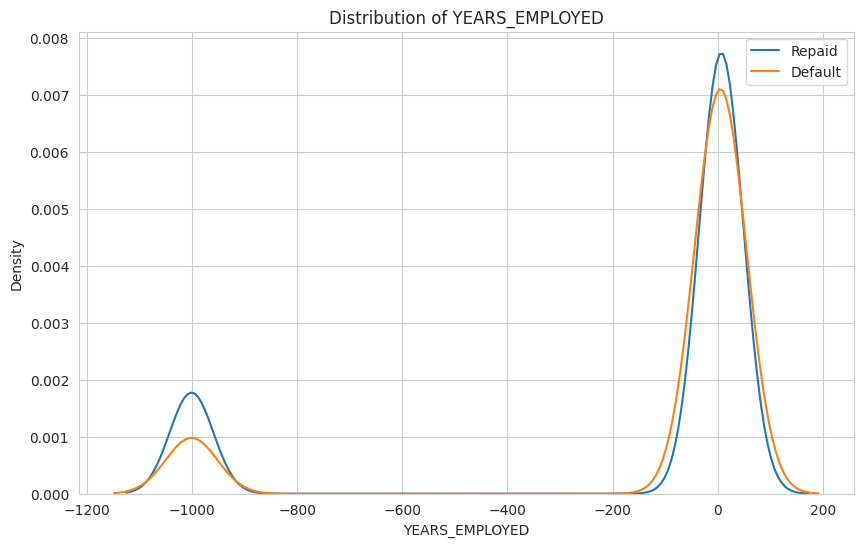

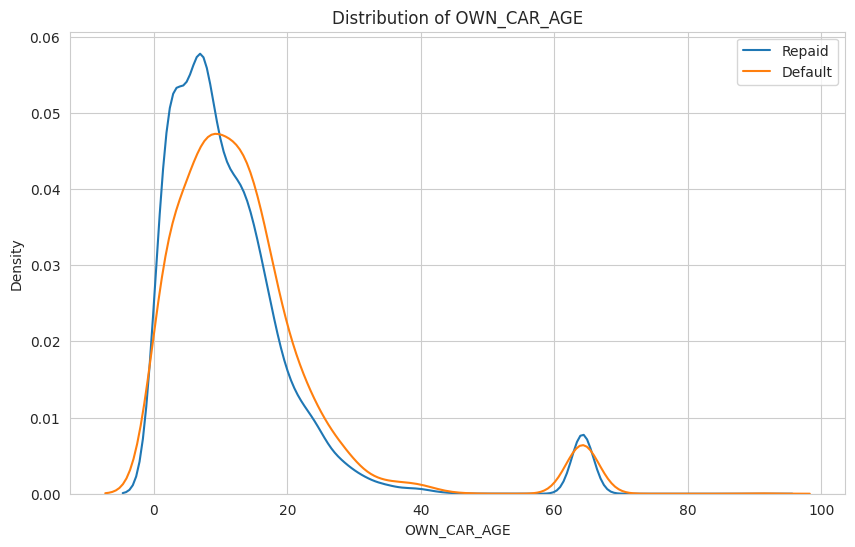

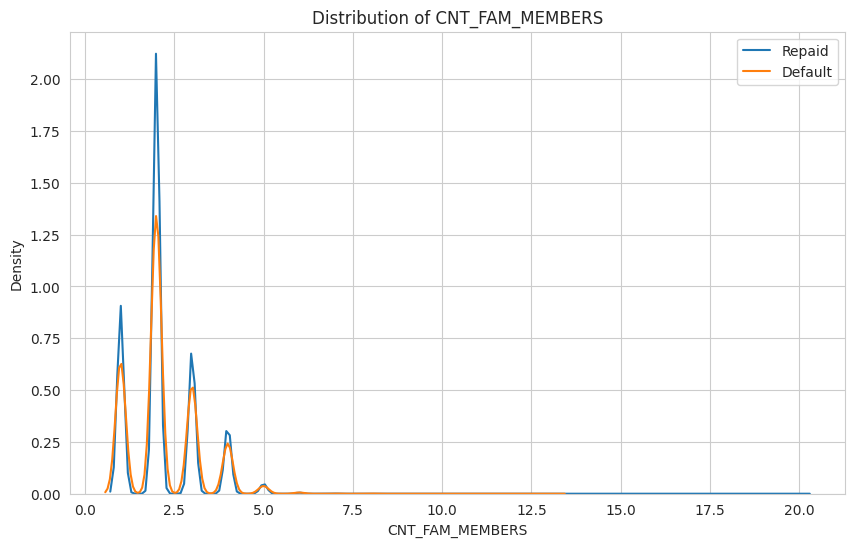

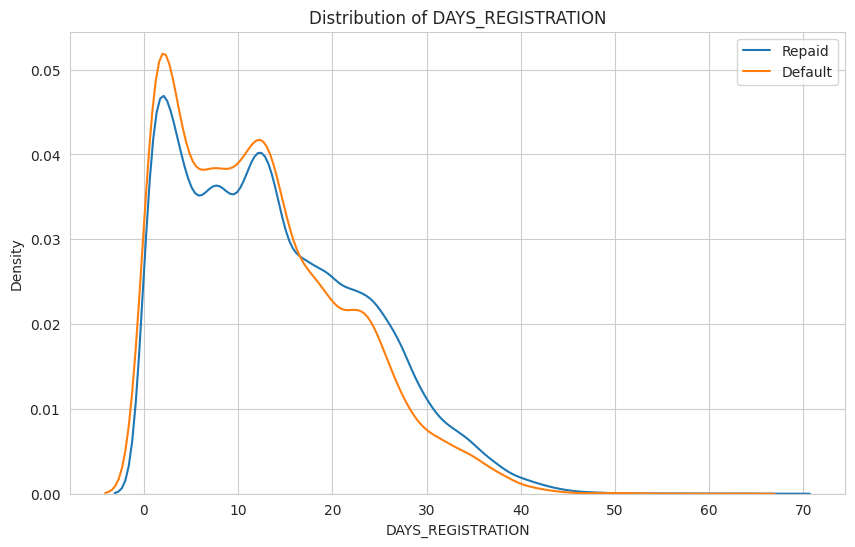

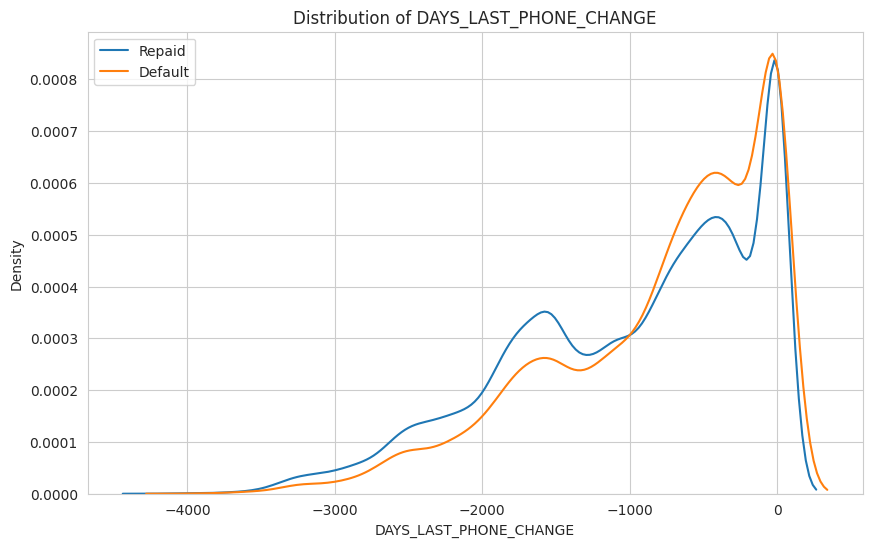

In [41]:
other_vars = [
    "AGE",
    "YEARS_EMPLOYED",
    "OWN_CAR_AGE",
    "CNT_FAM_MEMBERS",
    "DAYS_REGISTRATION",
    "DAYS_LAST_PHONE_CHANGE",
]
for v in other_vars:
    plot_distribution(v)


Younger people default slightly more often. Overall, demographic variables show limited discrimination individually; their usefulness is more likely in combination and via interactions (captured by non-linear models).


### 5.5 Correlation matrices


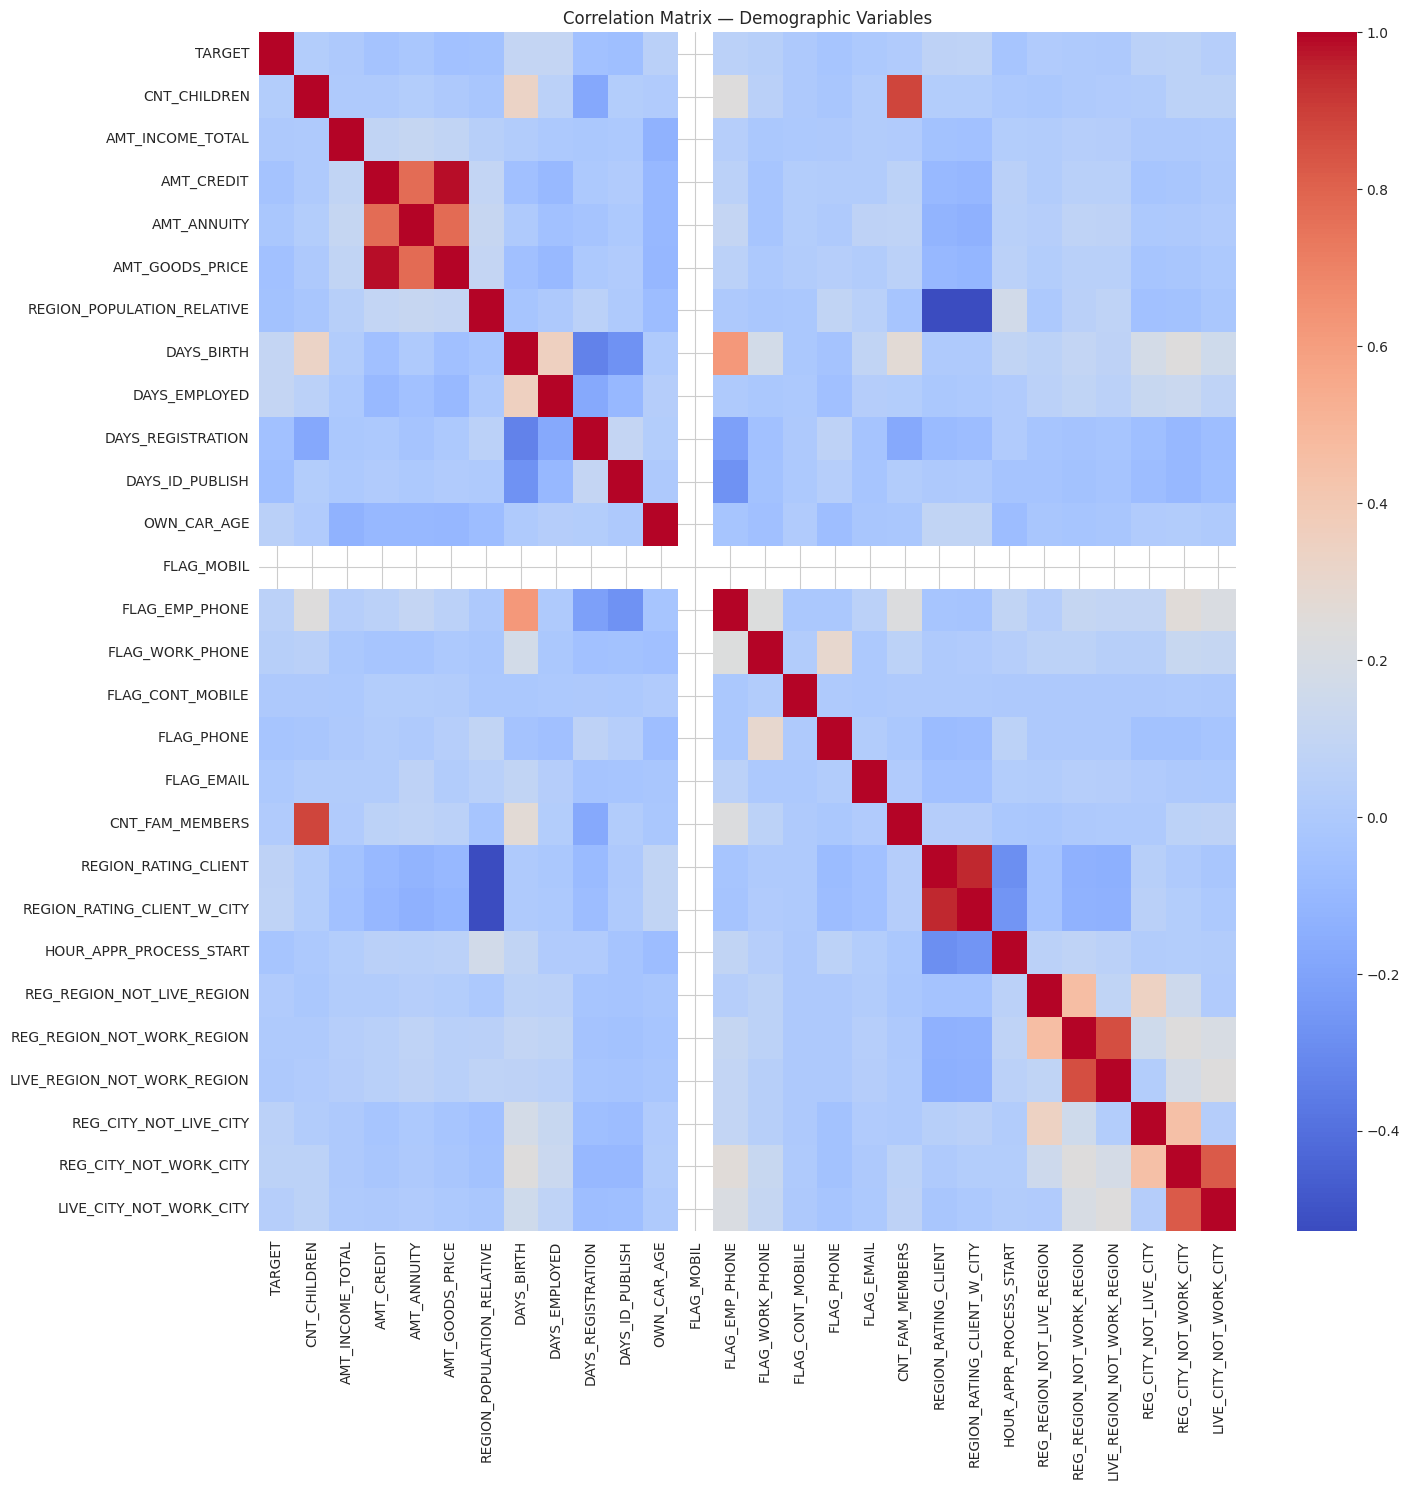

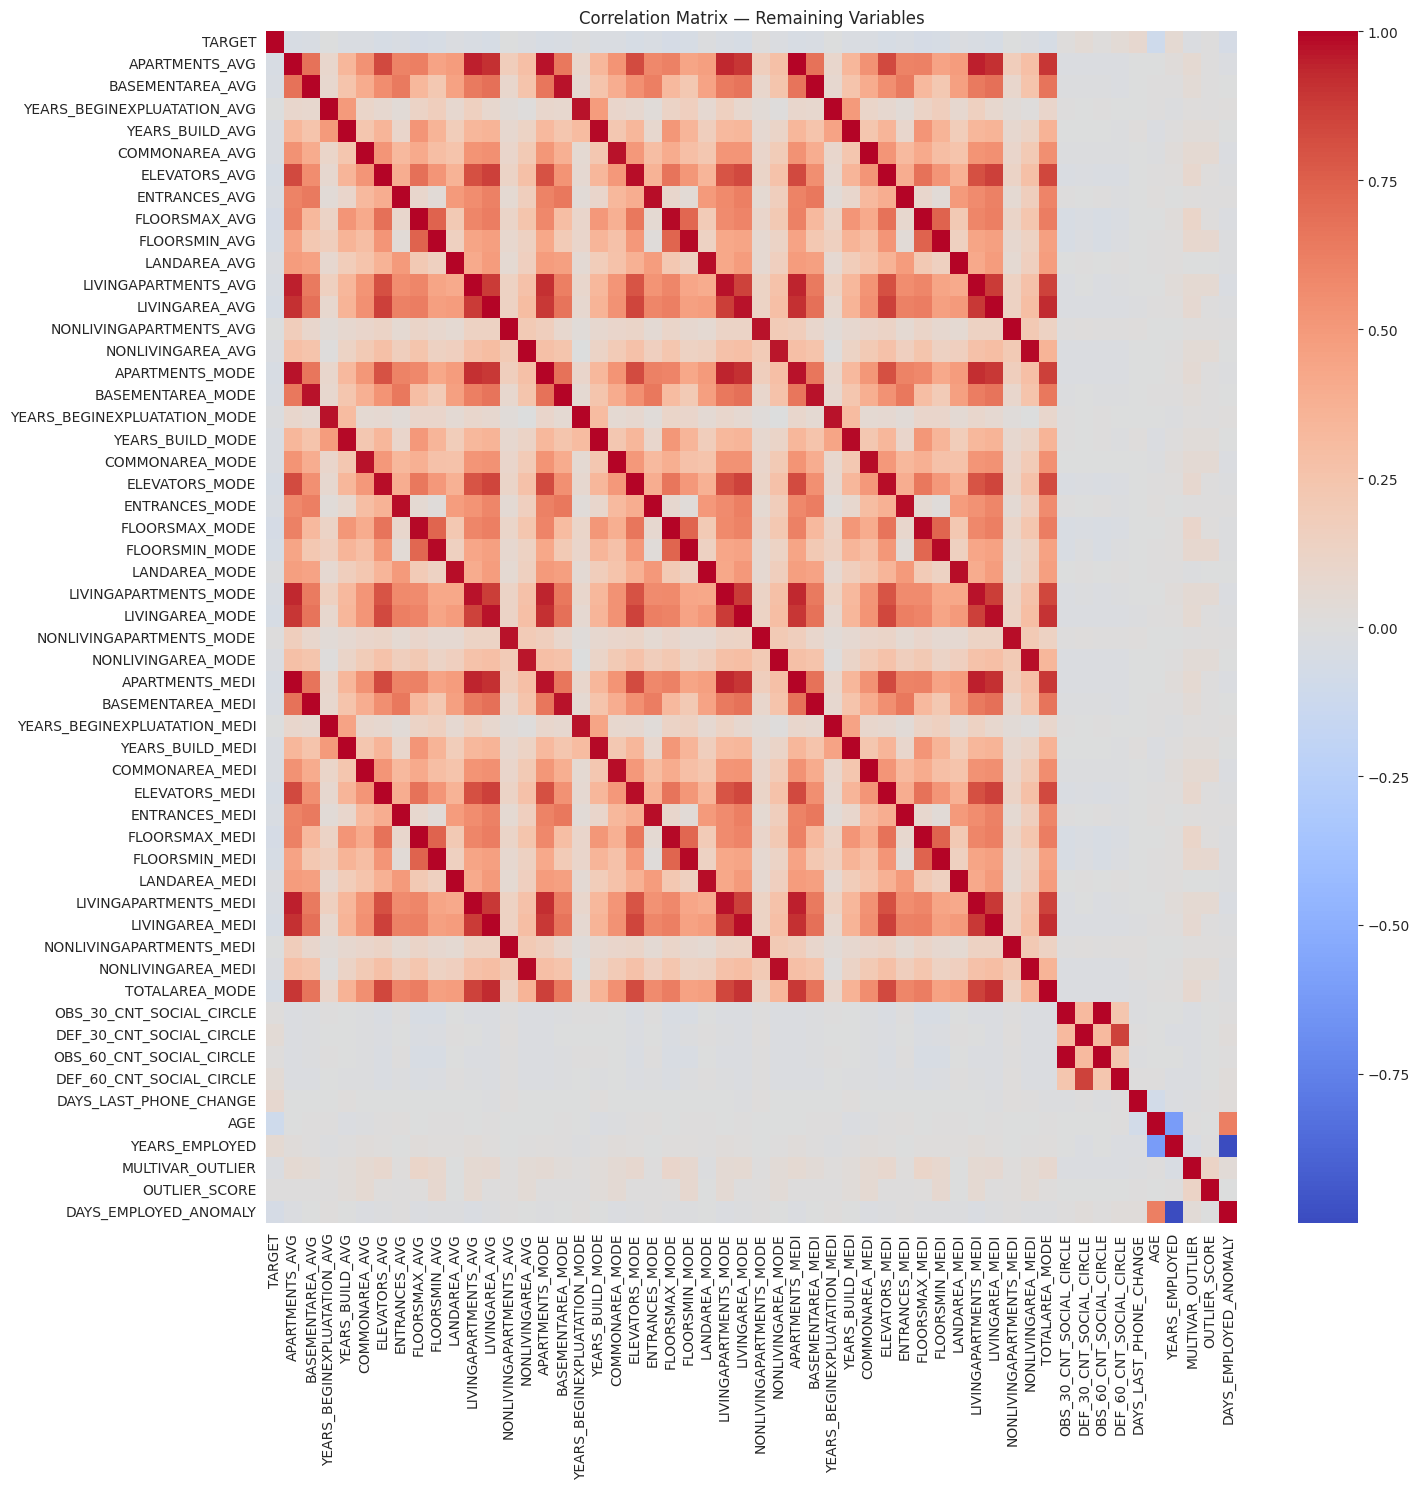

In [42]:
demo_subset = proj_data.columns[1:41]
corr_matrix_demo = proj_data[demo_subset].corr(numeric_only=True)

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_demo, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix — Demographic Variables")
plt.tight_layout()
plt.show()

remaining = proj_data.columns[40:]
corr_matrix_remaining = proj_data[["TARGET"] + list(remaining)].corr(numeric_only=True)

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_remaining, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix — Remaining Variables")
plt.tight_layout()
plt.show()


## 6) Categorical Variables — EDA


### 6.1 Convert object columns to categorical


In [43]:
num_cols = proj_data.select_dtypes(include=["int64", "float64"]).columns
cat_cols = proj_data.select_dtypes(include=["object"]).columns

# Convert object -> category for memory efficiency
for col in proj_data[cat_cols].columns:
    proj_data[col] = proj_data[col].astype("category")

proj_data.dtypes.to_frame().rename(columns={0: "dtype"})


,dtype
SK_ID_CURR,int64
TARGET,float64
NAME_CONTRACT_TYPE,category
CODE_GENDER,category
FLAG_OWN_CAR,category
...,...
AGE,float64
YEARS_EMPLOYED,float64
MULTIVAR_OUTLIER,float64
OUTLIER_SCORE,float64


> Note: categorical variables will be encoded (e.g., one-hot / target encoding) after the train/test split in Task 2 to avoid leakage.


### 6.2 Frequencies for categorical variables


In [44]:
if SAVE_AUDIT_FILES:
    # Save frequencies to a text file (useful for reporting)
    with open("frequencies.txt", "w") as freqout:
        for col in proj_data.select_dtypes(include=["category"]):
            print(
                col,
                "----------------------",
                "frequencies",
                proj_data[col].value_counts(dropna=False).sort_index(),
                "percentages",
                proj_data[col].value_counts(normalize=True).sort_index(),
                sep="\n\n",
                end="\n\n\n",
                file=freqout
            )
else:
    pass


### 6.3 Helper: default rate + count plots


In [45]:
def plot_rate_and_count(cat, display_type=None, df=proj_data, target="TARGET", palette="magma"):
    d = df[[cat, target]].copy()
    d[cat] = d[cat].astype("object").fillna("Missing")

    agg = d.groupby(cat)[target].agg(rate="mean", n="size").reset_index()

    order_rate = agg.sort_values("rate", ascending=False)[cat].tolist()
    order_n = agg.sort_values("n", ascending=False)[cat].tolist()

    if display_type == "over":
        fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(12, 10))

    sns.barplot(data=agg, x=cat, y="rate", order=order_rate,
                hue=cat, palette=palette, legend=False, errorbar=None, ax=ax[0])
    ax[0].set_title(f"Default rate by {cat}")
    ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[0].tick_params(axis="x", rotation=45)

    sns.barplot(data=agg, x=cat, y="n", order=order_n,
                hue=cat, palette=palette, legend=False, errorbar=None, ax=ax[1])
    ax[1].set_title(f"Count by {cat}")
    ax[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()
    return agg


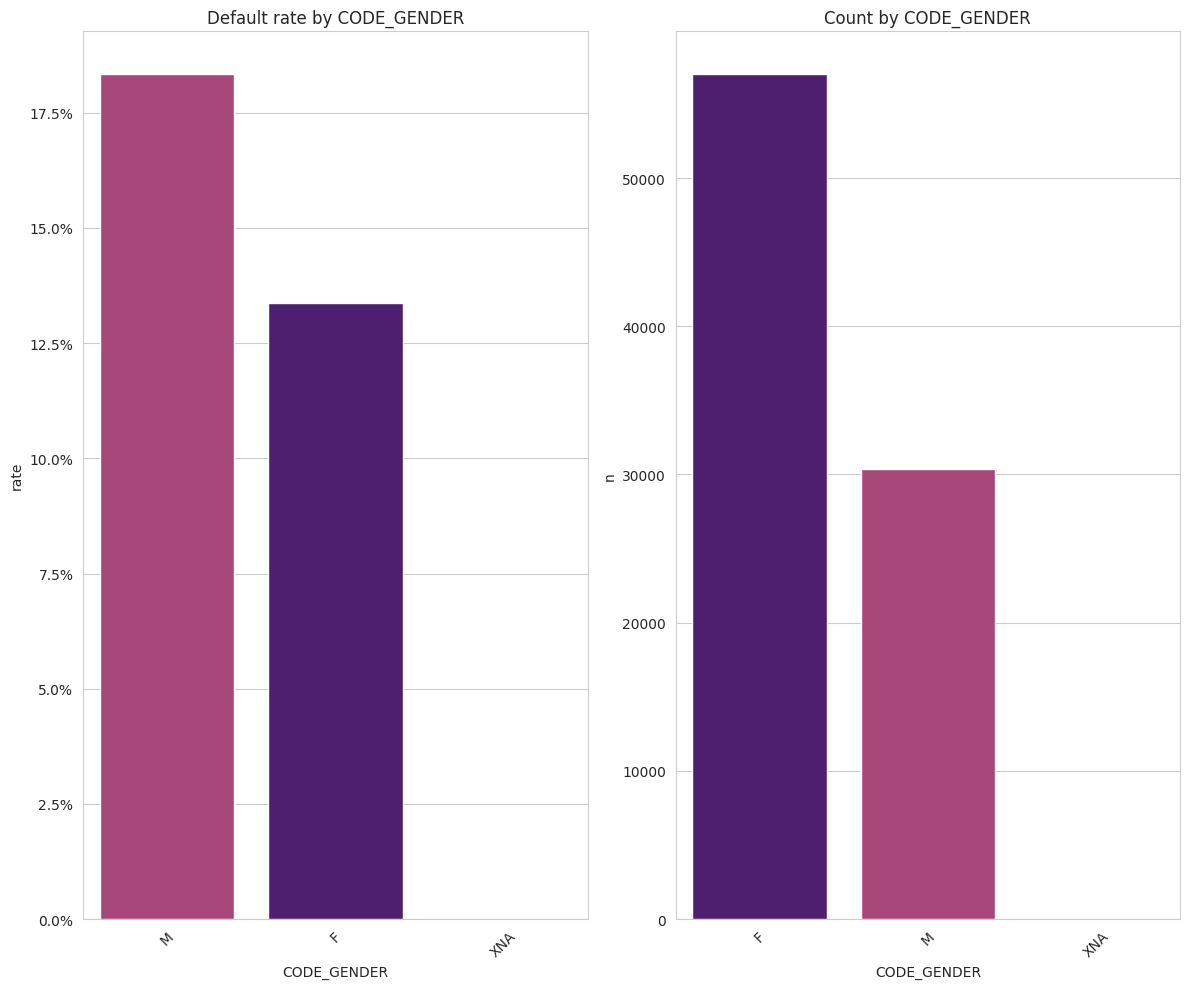

,CODE_GENDER,rate,n
0,F,0.133824,57045
1,M,0.183509,30380
2,XNA,0.000000,1


In [46]:
plot_rate_and_count(cat='CODE_GENDER')

Males take more loans and default more than females.
Because `CODE_GENDER` has only a very small number of rare values (`XNA`), I treat this as missing and later impute using the most frequent category within training folds.


In [47]:
proj_data.loc[proj_data["CODE_GENDER"] == "XNA", "CODE_GENDER"] = np.nan

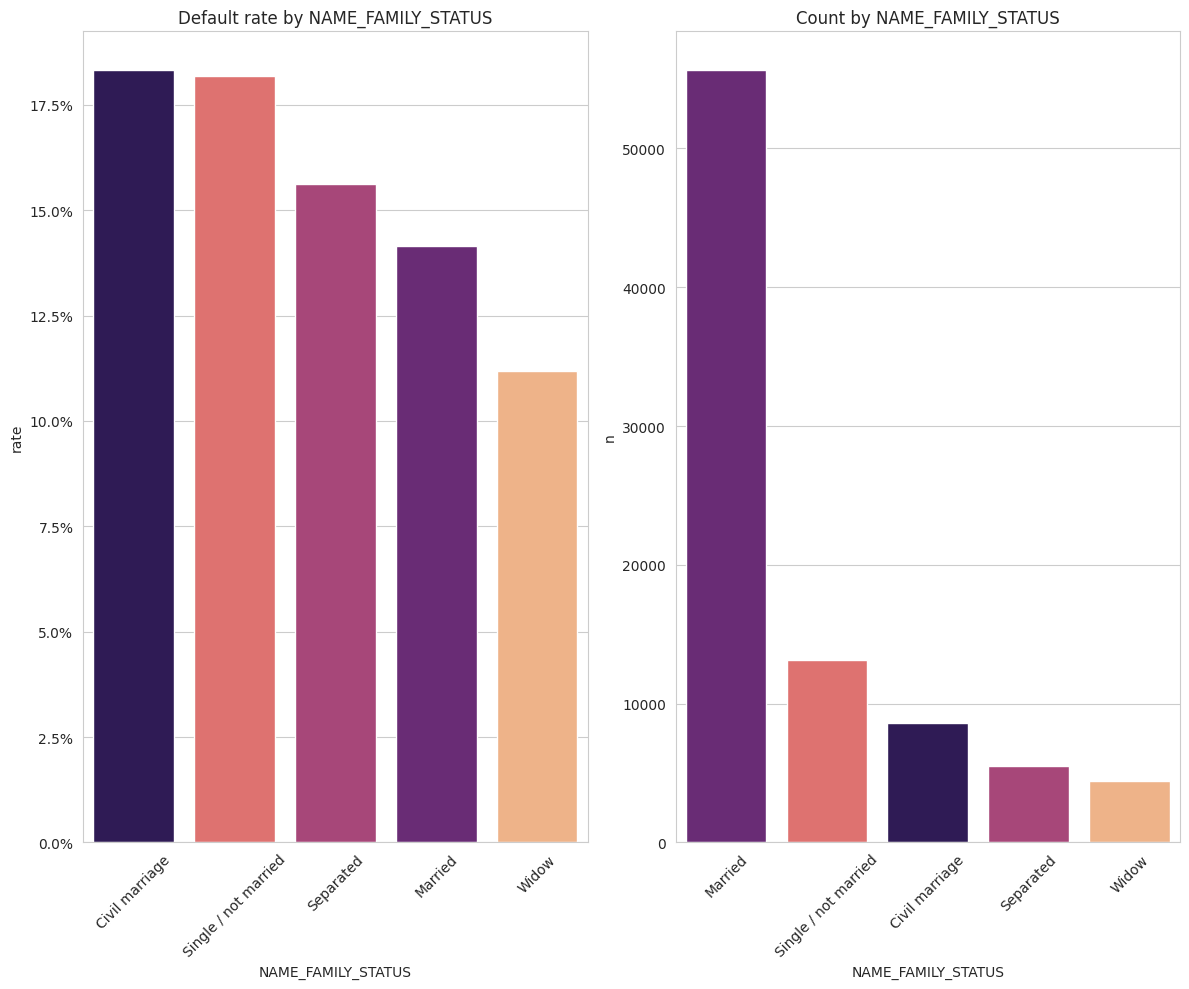

,NAME_FAMILY_STATUS,rate,n
0,Civil marriage,0.183252,8622
1,Married,0.141432,55652
2,Separated,0.156278,5535
3,Single / not married,0.181929,13170
4,Widow,0.111761,4447


In [48]:
plot_rate_and_count(cat='NAME_FAMILY_STATUS')

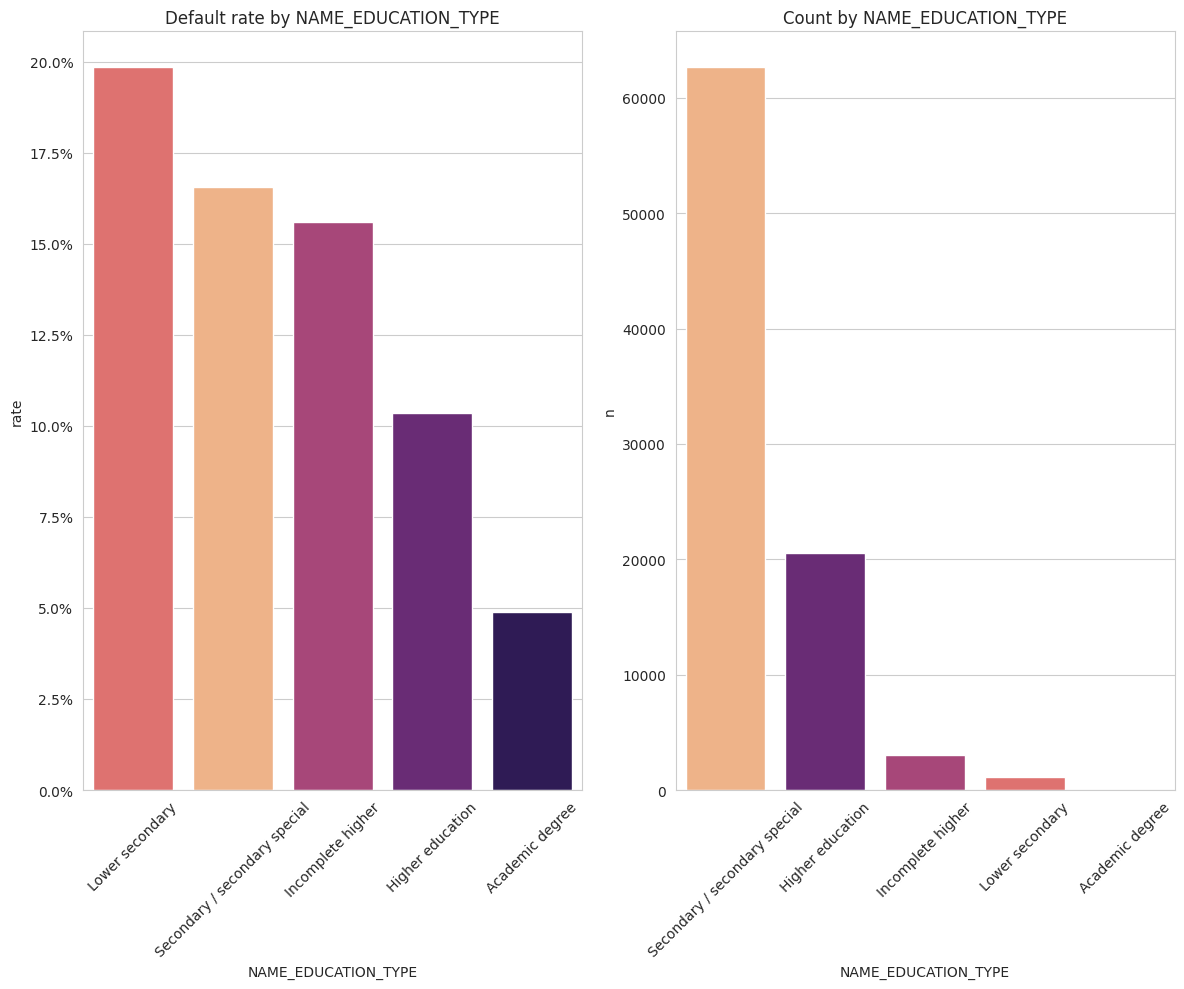

,NAME_EDUCATION_TYPE,rate,n
0,Academic degree,0.048780,41
1,Higher education,0.103648,20560
2,Incomplete higher,0.156098,3075
3,Lower secondary,0.198399,1124
4,Secondary / secondary special,0.165634,62626


In [49]:
plot_rate_and_count(cat='NAME_EDUCATION_TYPE')

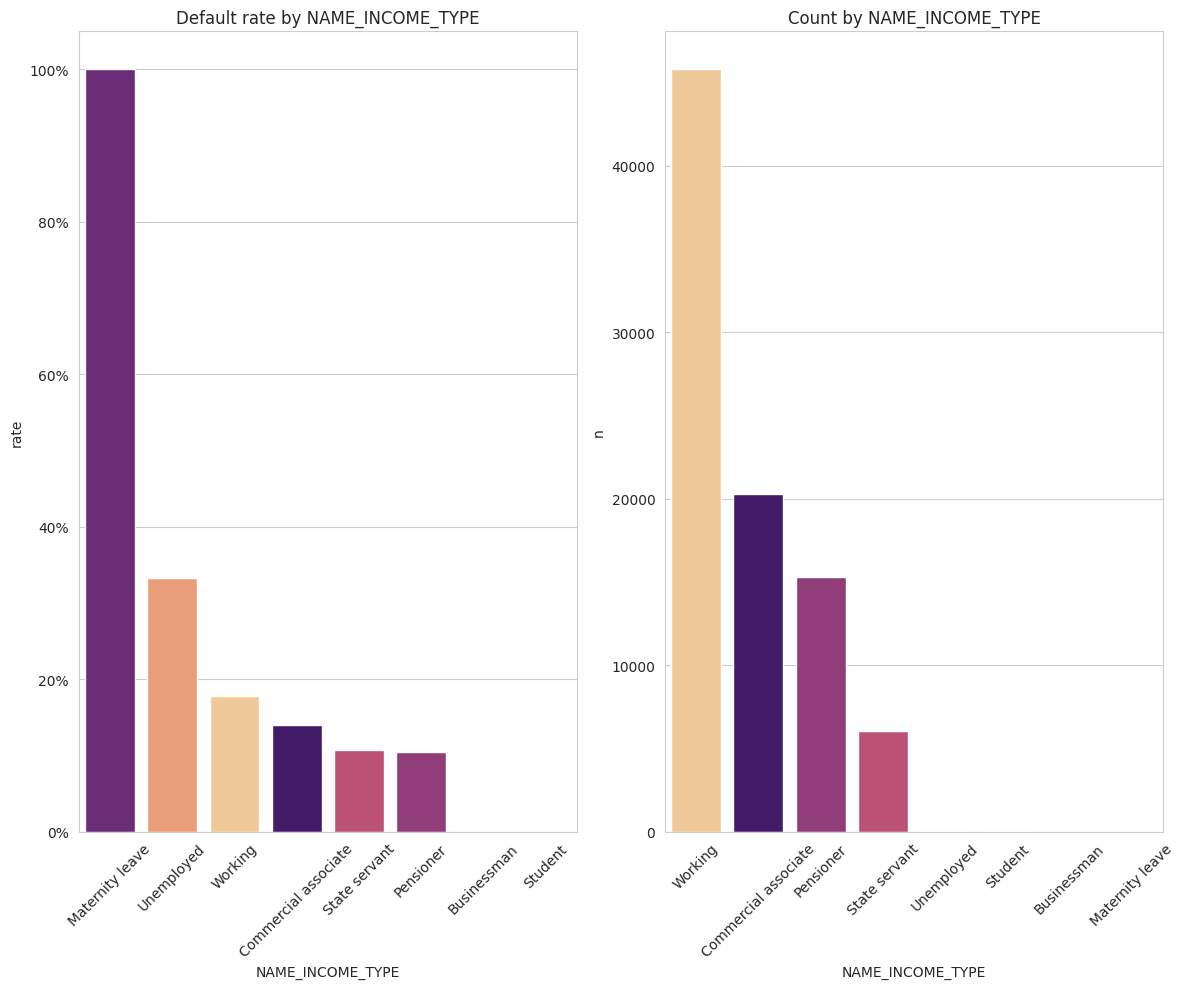

,NAME_INCOME_TYPE,rate,n
0,Businessman,0.000000,2
1,Commercial associate,0.139815,20284
2,Maternity leave,1.000000,1
3,Pensioner,0.104018,15305
4,State servant,0.106664,6047
5,Student,0.000000,5
6,Unemployed,0.333333,6
7,Working,0.177670,45776


In [50]:
plot_rate_and_count(cat='NAME_INCOME_TYPE')

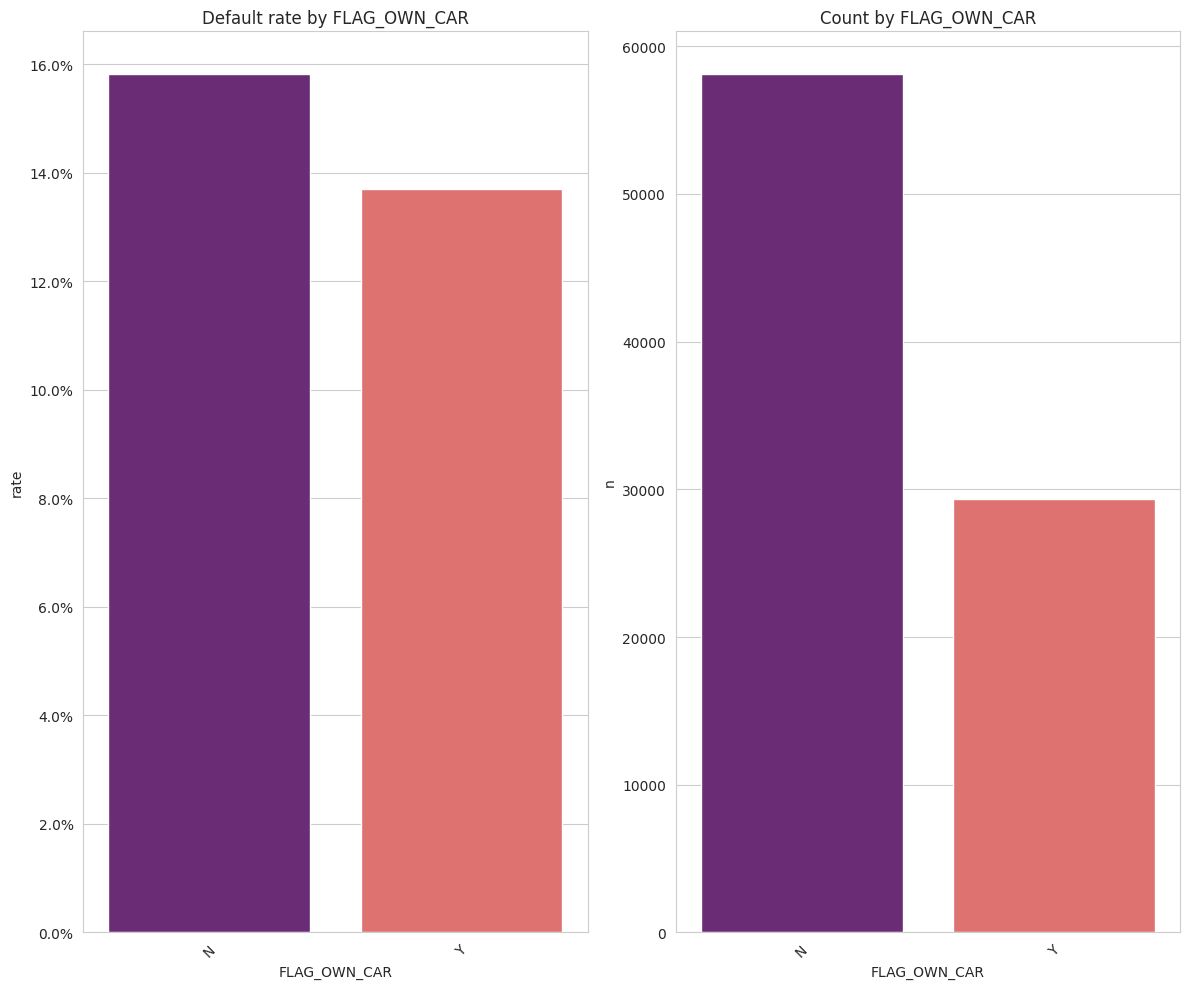

,FLAG_OWN_CAR,rate,n
0,N,0.158152,58096
1,Y,0.137095,29330


In [51]:
plot_rate_and_count(cat='FLAG_OWN_CAR')

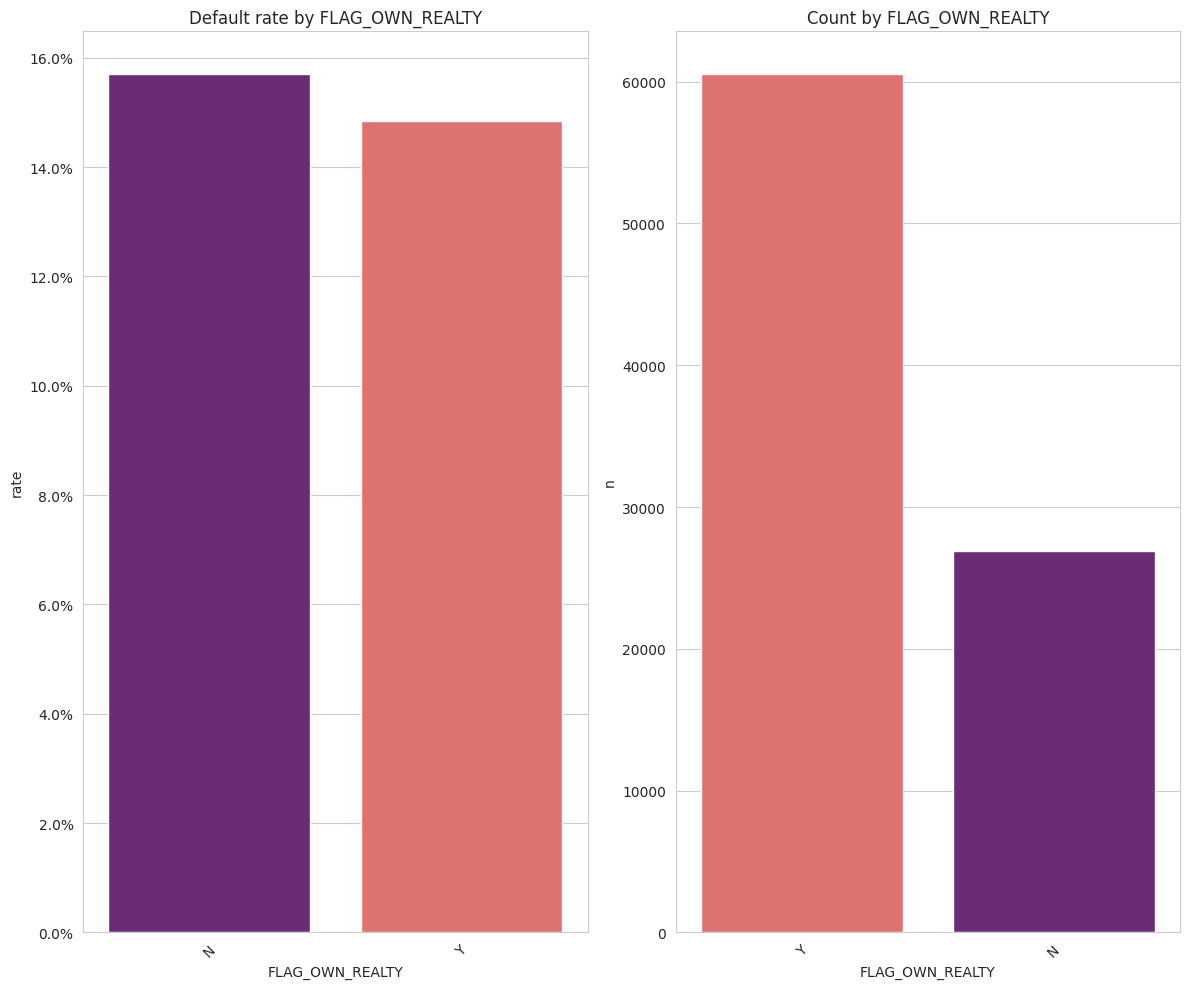

,FLAG_OWN_REALTY,rate,n
0,N,0.156991,26906
1,Y,0.148463,60520


In [52]:
plot_rate_and_count(cat='FLAG_OWN_REALTY')

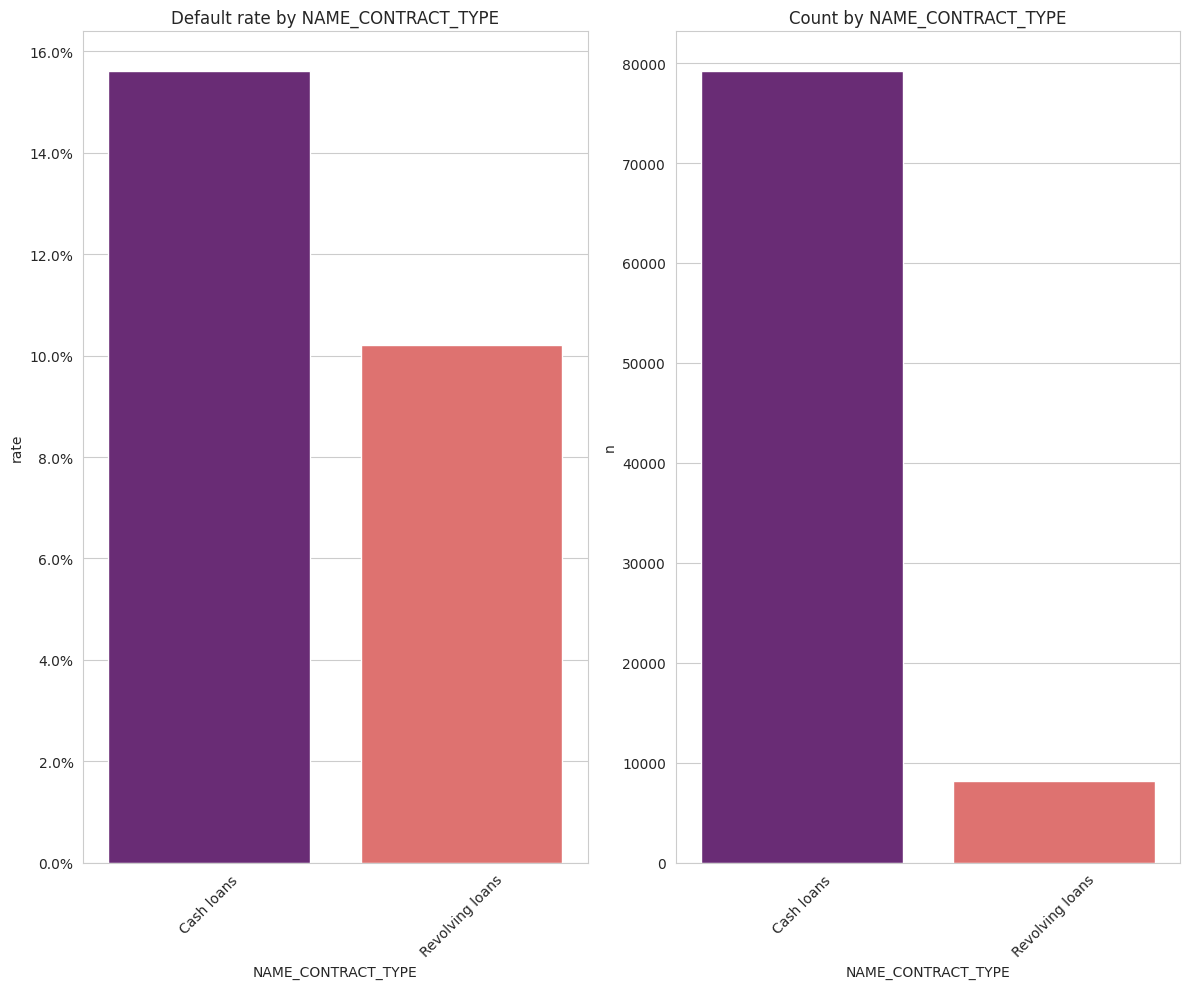

,NAME_CONTRACT_TYPE,rate,n
0,Cash loans,0.156159,79214
1,Revolving loans,0.102168,8212


In [53]:
plot_rate_and_count(cat='NAME_CONTRACT_TYPE')

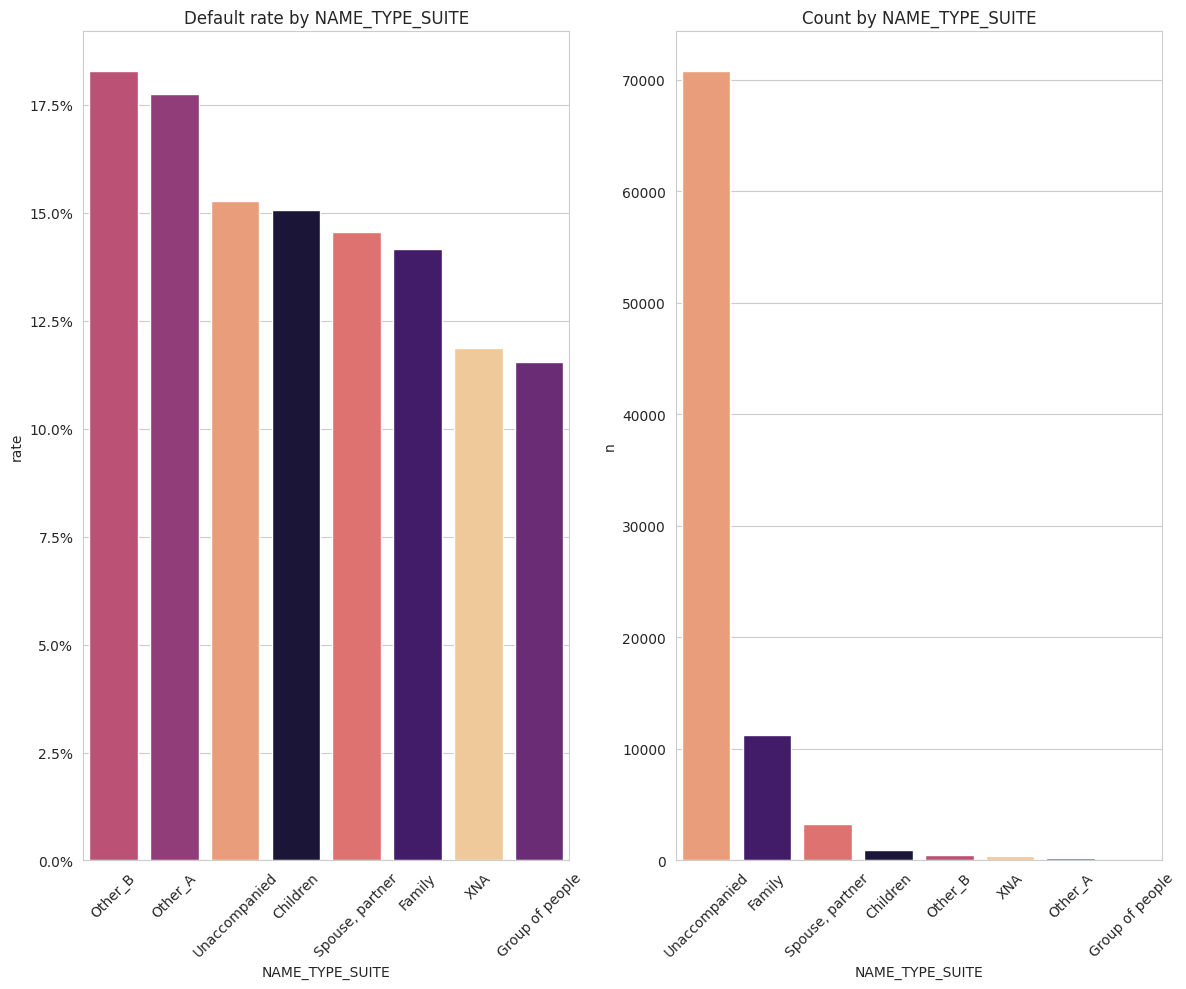

,NAME_TYPE_SUITE,rate,n
0,Children,0.150655,916
1,Family,0.141703,11263
2,Group of people,0.115385,78
3,Other_A,0.177606,259
4,Other_B,0.182879,514
5,"Spouse, partner",0.145511,3230
6,Unaccompanied,0.152717,70804
7,XNA,0.118785,362


In [54]:
plot_rate_and_count(cat='NAME_TYPE_SUITE')

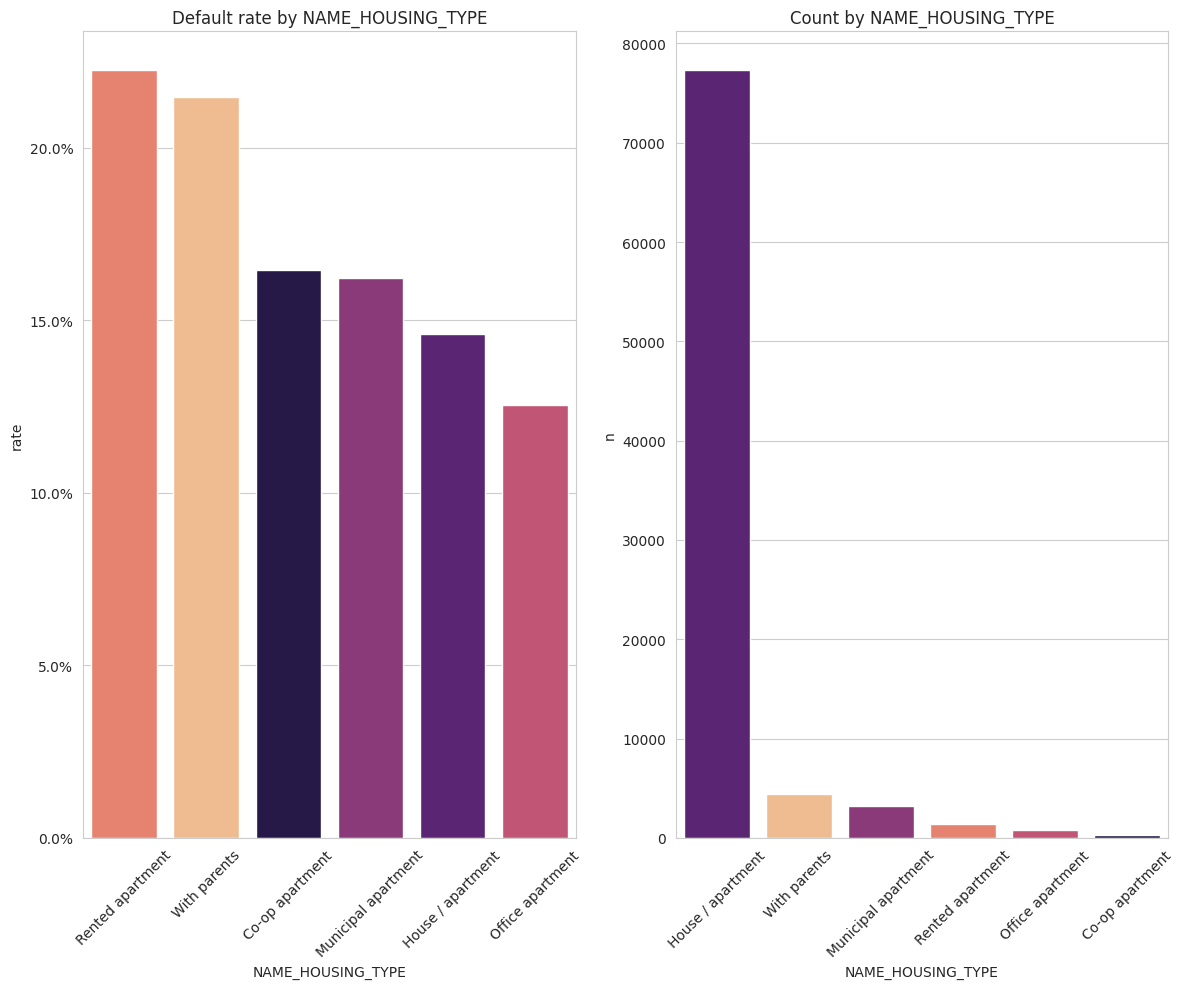

,NAME_HOUSING_TYPE,rate,n
0,Co-op apartment,0.164557,316
1,House / apartment,0.145886,77348
2,Municipal apartment,0.162289,3198
3,Office apartment,0.125501,749
4,Rented apartment,0.222533,1429
5,With parents,0.214774,4386


In [55]:
plot_rate_and_count(cat='NAME_HOUSING_TYPE')

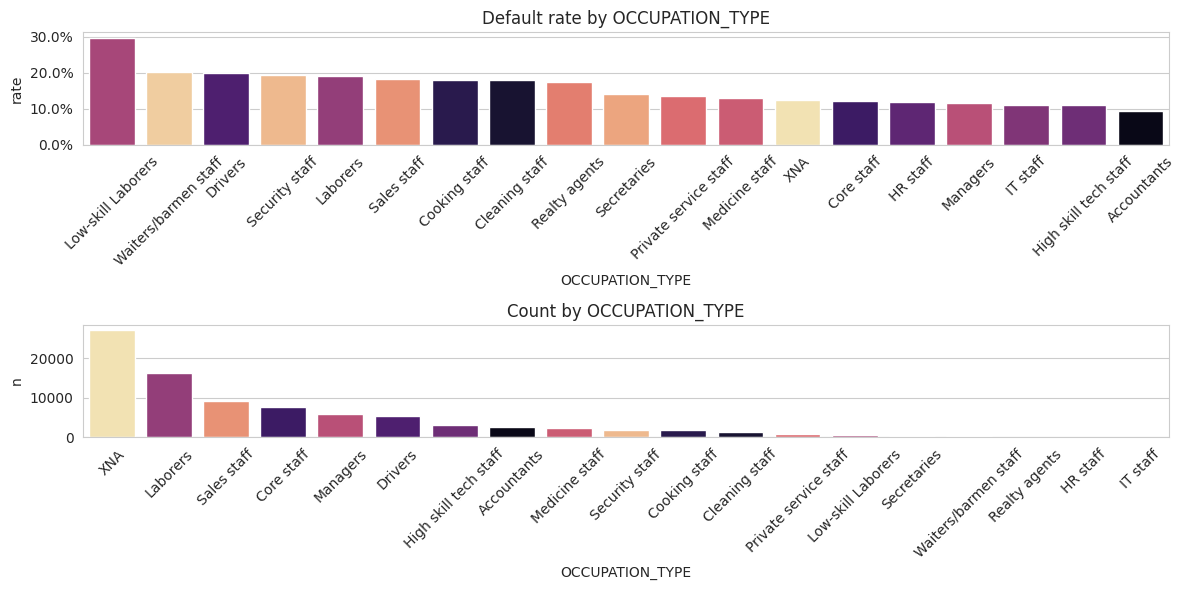

,OCCUPATION_TYPE,rate,n
0,Accountants,0.094347,2724
1,Cleaning staff,0.179928,1395
2,Cooking staff,0.180723,1743
3,Core staff,0.121866,7697
4,Drivers,0.198401,5504
5,HR staff,0.120253,158
6,High skill tech staff,0.110095,3170
7,IT staff,0.111842,152
8,Laborers,0.191727,16221
9,Low-skill Laborers,0.297030,606


In [56]:
plot_rate_and_count(cat='OCCUPATION_TYPE', display_type='over')

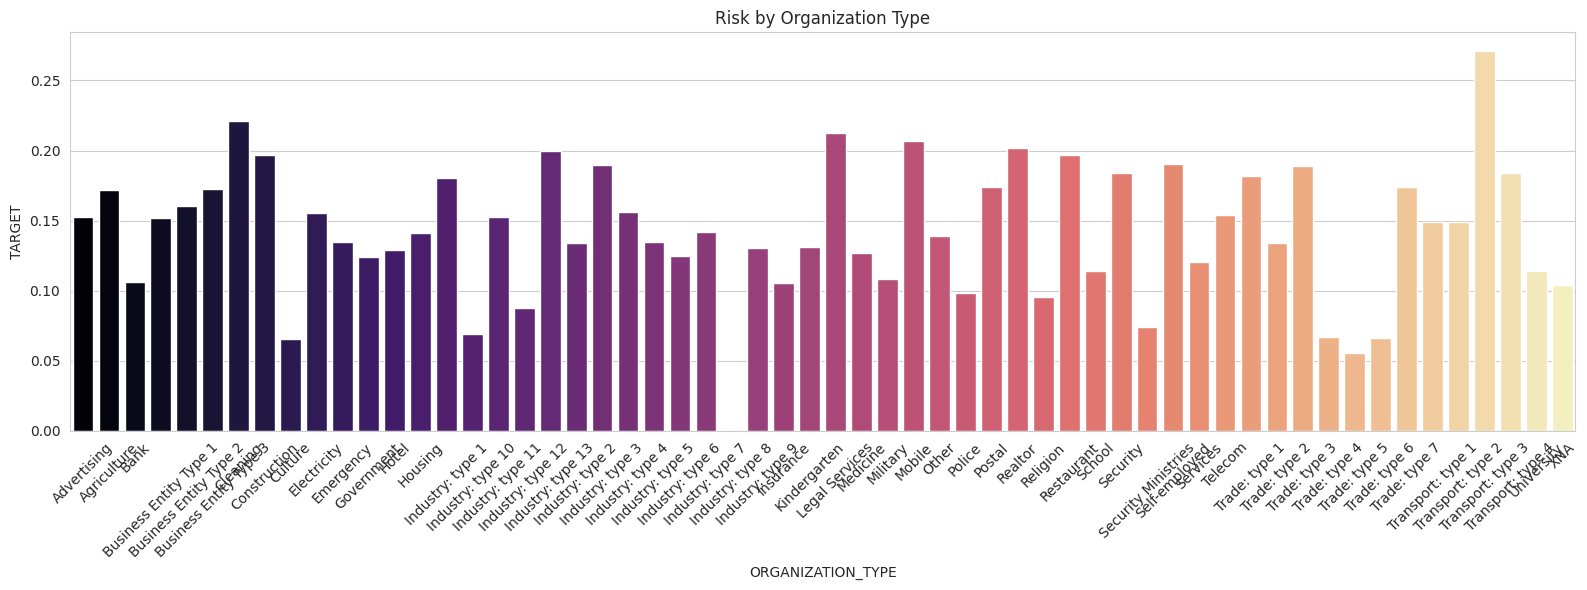

In [57]:
plt.figure(figsize=(16, 6))
sns.barplot(
    x="ORGANIZATION_TYPE",
    y="TARGET",
    data=proj_data,
    hue="ORGANIZATION_TYPE",
    palette="magma",
    errorbar=None,
    legend=False
)
plt.title("Risk by Organization Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


`ORGANIZATION_TYPE`, `OCCUPATION_TYPE`, and `NAME_HOUSING_TYPE` are high-cardinality features.  
In Task 2, I plan to use **target encoding** for these variables to reduce dimensionality and improve computational efficiency.


## 7) Dimensionality Reduction / Redundancy Checks


#### 7.1 Region/city mismatch variables


In [58]:
cols = [
    "REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION","LIVE_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"
]

corr = proj_data[cols].corr()
corr.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1).format("{:.2f}")


,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
REG_REGION_NOT_LIVE_REGION,1.00,0.46,0.09,0.34,0.15,0.02
REG_REGION_NOT_WORK_REGION,0.46,1.00,0.86,0.15,0.24,0.20
LIVE_REGION_NOT_WORK_REGION,0.09,0.86,1.00,0.02,0.19,0.24
REG_CITY_NOT_LIVE_CITY,0.34,0.15,0.02,1.00,0.45,0.03
REG_CITY_NOT_WORK_CITY,0.15,0.24,0.19,0.45,1.00,0.82
LIVE_CITY_NOT_WORK_CITY,0.02,0.20,0.24,0.03,0.82,1.00


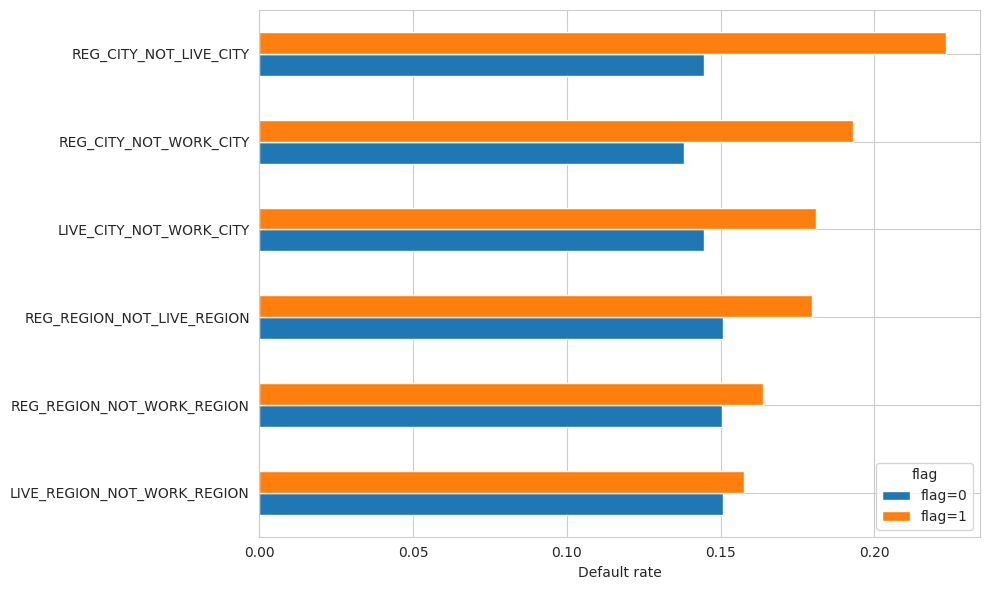

In [59]:
ycol = "TARGET"

plot_df = (
    proj_data[cols + [ycol]]
      .melt(id_vars=ycol, var_name="feature", value_name="flag")
      .dropna()
      .assign(flag=lambda d: d["flag"].astype(int))
      .groupby(["feature","flag"])[ycol]
      .mean()
      .reset_index(name="default_rate")
)

piv = plot_df.pivot(index="feature", columns="flag", values="default_rate").rename(columns={0:"flag=0", 1:"flag=1"})

ax = piv.sort_values("flag=1").plot(kind="barh", figsize=(10, 6))
ax.set_xlabel("Default rate")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


I observe strong redundancy:
- `REG_REGION_NOT_WORK_REGION` and `LIVE_REGION_NOT_WORK_REGION` are highly correlated and have similar default rates.
- `REG_CITY_NOT_WORK_CITY` and `LIVE_CITY_NOT_WORK_CITY` are highly correlated and have similar default rates.
To preserve signal while reducing redundancy, I create combined indicators.


In [60]:
proj_data["ANY_WORK_REGION_MISMATCH"] = (
    (proj_data["REG_REGION_NOT_WORK_REGION"] == 1) | (proj_data["LIVE_REGION_NOT_WORK_REGION"] == 1)
).astype(int)

proj_data["ANY_WORK_CITY_MISMATCH"] = (
    (proj_data["REG_CITY_NOT_WORK_CITY"] == 1) | (proj_data["LIVE_CITY_NOT_WORK_CITY"] == 1)
).astype(int)

#### 7.2 Financial variables: `AMT_CREDIT` vs `AMT_GOODS_PRICE`


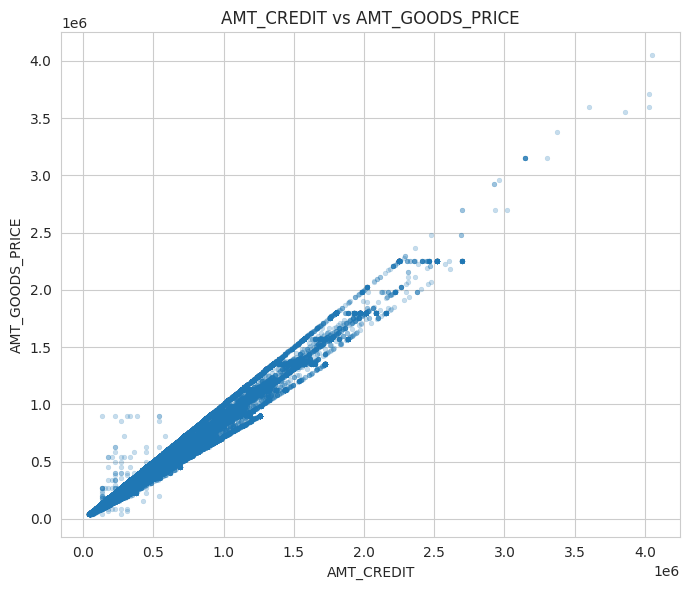

In [61]:
mask = proj_data["AMT_CREDIT"] == proj_data["AMT_GOODS_PRICE"]
proj_data.loc[mask, ["AMT_CREDIT", "AMT_GOODS_PRICE"]].mean()

dfp = proj_data[["AMT_CREDIT", "AMT_GOODS_PRICE"]].dropna()
plt.figure(figsize=(7, 6))
ax = sns.scatterplot(data=dfp, x="AMT_CREDIT", y="AMT_GOODS_PRICE", s=12, alpha=0.25, edgecolor=None)
ax.set_title("AMT_CREDIT vs AMT_GOODS_PRICE")
ax.set_xlabel("AMT_CREDIT")
ax.set_ylabel("AMT_GOODS_PRICE")
plt.tight_layout()
plt.show()

The scatter plot shows a near-perfect linear relationship between `AMT_CREDIT` and `AMT_GOODS_PRICE`, indicating redundancy.
To reduce multicollinearity for linear models, I later keep only one of the raw variables and engineer a ratio such as `AMT_CREDIT / AMT_GOODS_PRICE` to capture deviations.


#### 7.3 Household composition: `CNT_CHILDREN` vs `CNT_FAM_MEMBERS`


In [62]:
tdf = proj_data[["CNT_CHILDREN", "CNT_FAM_MEMBERS", "TARGET"]].dropna()
(tdf["CNT_CHILDREN"] > tdf["CNT_FAM_MEMBERS"]).mean(), tdf[tdf["CNT_CHILDREN"] > tdf["CNT_FAM_MEMBERS"]].head()


(np.float64(0.0),
 Empty DataFrame
 Columns: [CNT_CHILDREN, CNT_FAM_MEMBERS, TARGET]
 Index: [])

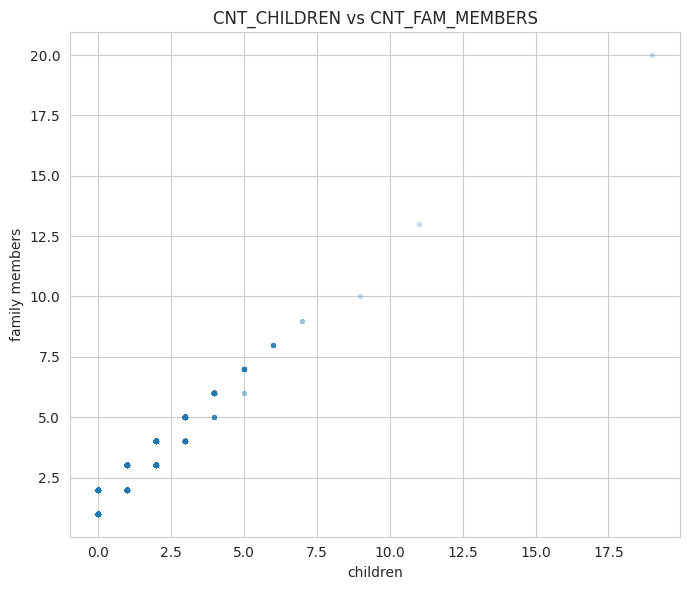

In [63]:
dfp = proj_data[["CNT_CHILDREN", "CNT_FAM_MEMBERS"]].dropna()

plt.figure(figsize=(7, 6))
ax = sns.scatterplot(data=dfp, x="CNT_CHILDREN", y="CNT_FAM_MEMBERS", s=12, alpha=0.25, edgecolor=None)
ax.set_title("CNT_CHILDREN vs CNT_FAM_MEMBERS")
ax.set_xlabel("children")
ax.set_ylabel("family members")
plt.tight_layout()
plt.show()

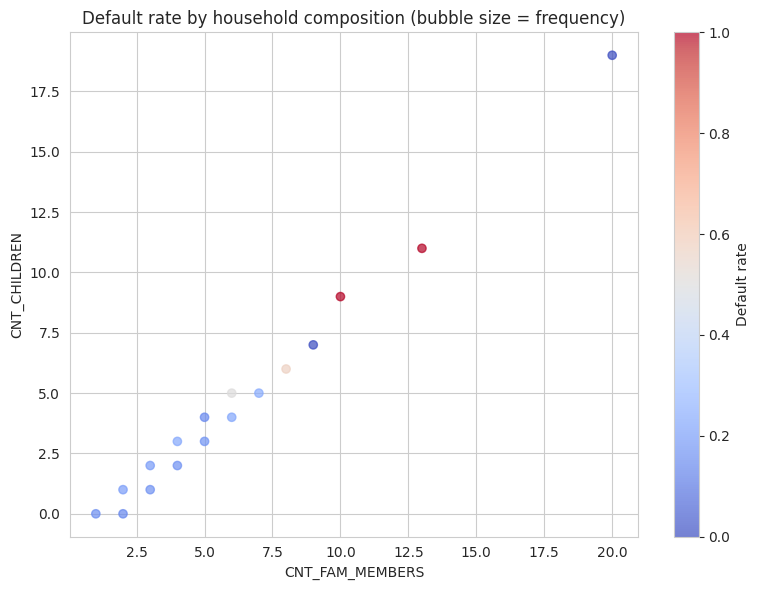

In [64]:
summary = (
    proj_data.groupby(["CNT_FAM_MEMBERS","CNT_CHILDREN"])["TARGET"]
       .agg(n="size", rate="mean")
       .reset_index()
)

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    summary["CNT_FAM_MEMBERS"],
    summary["CNT_CHILDREN"],
    c=summary["rate"],
    cmap="coolwarm",
    alpha=0.7
)
plt.colorbar(sc, label="Default rate")
plt.xlabel("CNT_FAM_MEMBERS")
plt.ylabel("CNT_CHILDREN")
plt.title("Default rate by household composition (bubble size = frequency)")
plt.tight_layout()
plt.show()

- `CNT_CHILDREN` is almost a deterministic function of `CNT_FAM_MEMBERS`.
- Larger households tend to have higher default rates.
- Including both variables can create near-perfect multicollinearity for linear models.
Therefore, I keep `CNT_FAM_MEMBERS` and plan to drop `CNT_CHILDREN`.


#### 7.4 Region rating redundancy


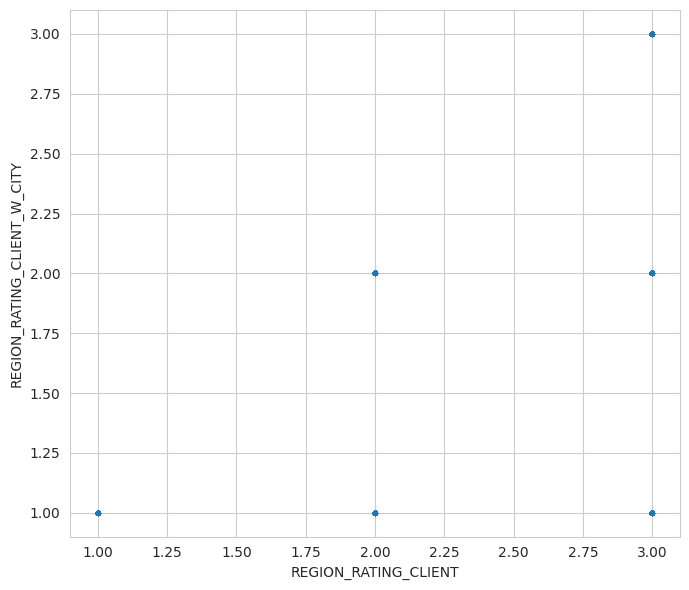

,col,%missing,%zero,%nonzero,mean,std
0,REGION_RATING_CLIENT,0.0,0.0,1.0,2.063059,0.510786
1,REGION_RATING_CLIENT_W_CITY,0.0,0.0,1.0,2.041338,0.505080


In [65]:
dfp = proj_data[["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"]].dropna()
plt.figure(figsize=(7, 6))
sns.scatterplot(data=dfp, x="REGION_RATING_CLIENT", y="REGION_RATING_CLIENT_W_CITY", s=12, alpha=0.25, edgecolor=None)
plt.tight_layout()
plt.show()

summ = []
for col in ["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"]:
    summ.append({
        "col": col,
        "%missing": proj_data[col].isna().mean(),
        "%zero": (proj_data[col] == 0).mean(),
        "%nonzero": (proj_data[col] != 0).mean(),
        "mean": proj_data[col].mean(),
        "std": proj_data[col].std(),
    })
pd.DataFrame(summ)


In [66]:
def overlap_counts(a, b):
    A = proj_data[a].fillna(-1)
    B = proj_data[b].fillna(-1)
    both_nonmiss = (A != -1) & (B != -1)
    return pd.Series({
        "pct_equal_all": (A == B).mean(),
        "pct_equal_nonmiss": (A[both_nonmiss] == B[both_nonmiss]).mean() if both_nonmiss.any() else np.nan
    })

overlap_counts("REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY")


,0
pct_equal_all,0.980807
pct_equal_nonmiss,0.980807


Given the ~98% overlap and near-identical distributions, I keep only one rating.  
To reduce multicollinearity, I retain `REGION_RATING_CLIENT`, which shows slightly higher variability.


#### 7.5 Social circle redundancy


In [67]:
proj_data[["OBS_30_CNT_SOCIAL_CIRCLE","OBS_60_CNT_SOCIAL_CIRCLE",
           "DEF_30_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"]].corr()


,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
OBS_30_CNT_SOCIAL_CIRCLE,1.000000,0.998302,0.312712,0.237882
OBS_60_CNT_SOCIAL_CIRCLE,0.998302,1.000000,0.315405,0.240191
DEF_30_CNT_SOCIAL_CIRCLE,0.312712,0.315405,1.000000,0.857871
DEF_60_CNT_SOCIAL_CIRCLE,0.237882,0.240191,0.857871,1.000000


In [68]:
cols = ["OBS_30_CNT_SOCIAL_CIRCLE","OBS_60_CNT_SOCIAL_CIRCLE",
        "DEF_30_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"]

summ = []
for col in cols:
    summ.append({
        "col": col,
        "%missing": proj_data[col].isna().mean(),
        "%zero": (proj_data[col] == 0).mean(),
        "%nonzero": (proj_data[col] != 0).mean(),
        "mean": proj_data[col].mean(),
        "std": proj_data[col].std(),
    })
pd.DataFrame(summ)


,col,%missing,%zero,%nonzero,mean,std
0,OBS_30_CNT_SOCIAL_CIRCLE,0.003134,0.530998,0.469002,1.429009,2.310453
1,OBS_60_CNT_SOCIAL_CIRCLE,0.003134,0.533365,0.466635,1.411580,2.289374
2,DEF_30_CNT_SOCIAL_CIRCLE,0.003134,0.879510,0.120490,0.147627,0.449573
3,DEF_60_CNT_SOCIAL_CIRCLE,0.003134,0.911182,0.088818,0.102465,0.364533


In [69]:
overlap_counts('OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE')

,0
pct_equal_all,0.983254
pct_equal_nonmiss,0.983202


In [70]:
overlap_counts('DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE')

,0
pct_equal_all,0.959646
pct_equal_nonmiss,0.959519


In [71]:
mask = proj_data["OBS_30_CNT_SOCIAL_CIRCLE"] != proj_data["OBS_60_CNT_SOCIAL_CIRCLE"]
proj_data.loc[mask, ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE"]].head()


,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
66,3.0,2.0
132,2.0,1.0
230,2.0,1.0
232,2.0,1.0
311,NaN,NaN


These variables are highly correlated and overlap for most observations.  
I keep the 30-day versions (slightly fewer zeros / more information) and drop the 60-day versions later.


#### 7.6 Apartment characteristics suffixes (AVG/MEDI/MODE)


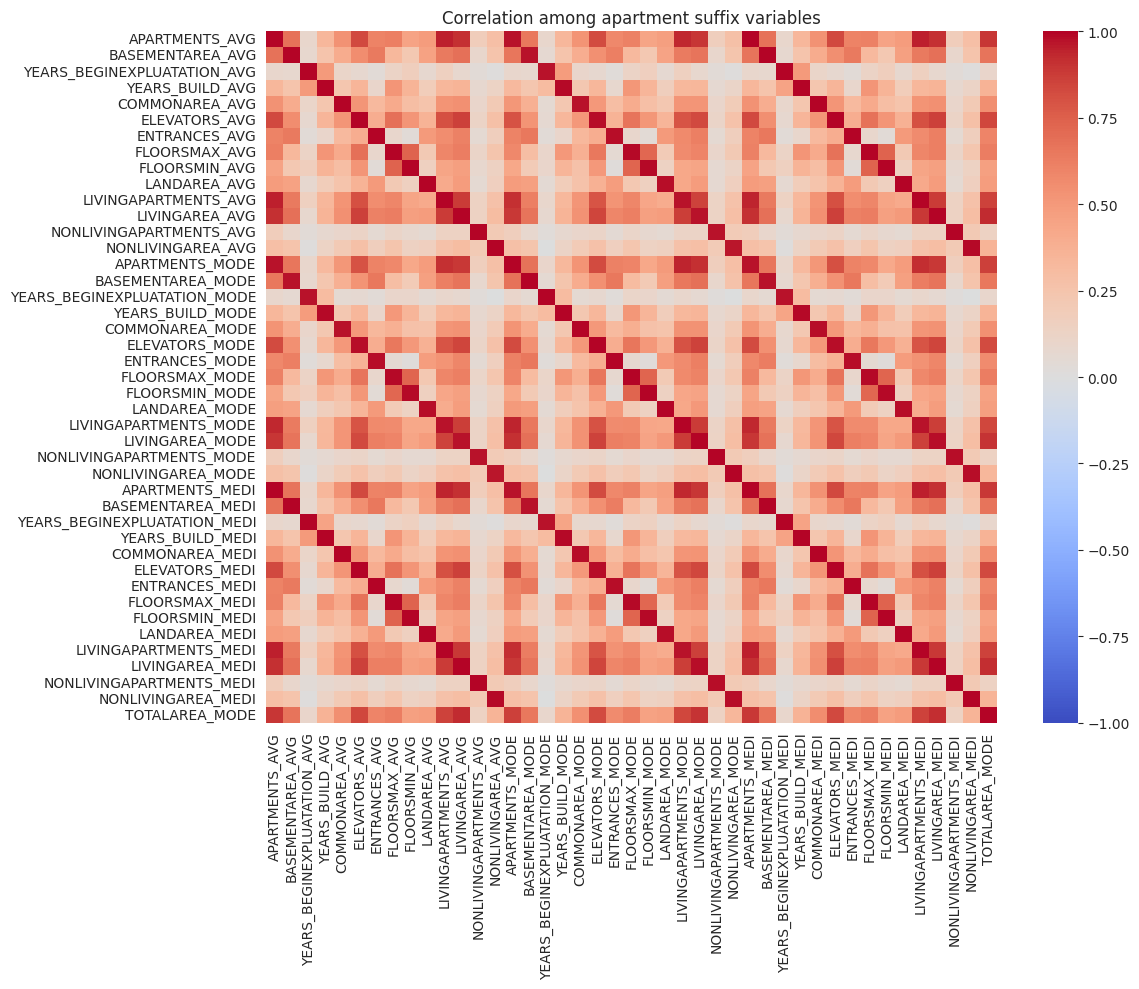

In [72]:
cols = proj_data.columns[proj_data.columns.str.endswith(("_AVG", "_MODE", "_MEDI"))]
corr = proj_data[cols].corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation among apartment suffix variables")
plt.tight_layout()
plt.show()


AVG/MEDI/MODE versions of the apartment variables are highly correlated.  
I keep only the **AVG** versions and drop `*_MEDI` and `*_MODE` later.


In [73]:
cols_avg = proj_data.columns[proj_data.columns.str.endswith("_AVG")]
corr = proj_data[cols_avg].corr(numeric_only=True)

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
top_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .reset_index()
         .rename(columns={"level_0":"var1","level_1":"var2", 0:"corr"})
)
top_pairs.head(10)


,var1,var2,corr
0,APARTMENTS_AVG,LIVINGAPARTMENTS_AVG,0.947508
1,APARTMENTS_AVG,LIVINGAREA_AVG,0.910762
2,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,0.882246
3,ELEVATORS_AVG,LIVINGAREA_AVG,0.862491
4,APARTMENTS_AVG,ELEVATORS_AVG,0.835166
5,ELEVATORS_AVG,LIVINGAPARTMENTS_AVG,0.809042
6,FLOORSMAX_AVG,FLOORSMIN_AVG,0.742082
7,BASEMENTAREA_AVG,LIVINGAREA_AVG,0.684524
8,ELEVATORS_AVG,FLOORSMAX_AVG,0.680345
9,APARTMENTS_AVG,BASEMENTAREA_AVG,0.672783


These housing variables are correlated because they measure related aspects of housing quality, but they are not near-identical duplicates.  
I keep them and let the modeling stage decide their relevance. For linear models, multicollinearity will be addressed via regularization.


## 8) Feature Engineering


### 8.1 Create derived financial variables


In [74]:
proj_data["CREDIT_TO_GOODS"] = proj_data["AMT_CREDIT"] / proj_data["AMT_GOODS_PRICE"]
proj_data["CREDIT_TO_INCOME"] = proj_data["AMT_CREDIT"] / proj_data["AMT_INCOME_TOTAL"]
proj_data["ANNUITY_TO_INCOME"] = proj_data["AMT_ANNUITY"] / proj_data["AMT_INCOME_TOTAL"]
proj_data["PAYMENT_RATE"] = proj_data["AMT_ANNUITY"] / proj_data["AMT_CREDIT"]
proj_data.replace([np.inf, -np.inf], np.nan, inplace=True)

proj_data["DEFAULT_RATE_30_SOCIAL_CIRCLE"] = proj_data["DEF_30_CNT_SOCIAL_CIRCLE"] / proj_data["OBS_30_CNT_SOCIAL_CIRCLE"]

# Contact info summary (count of provided channels)
proj_data["CONTACT_INFO_PROVIDED"] = proj_data[["FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]].sum(axis=1)


## 9) Filter Dataset


### 9.1 Remove non-modeling columns


I remove identifiers and some variables I do not plan to model in this project setup.
> Note: `WEEKDAY_APPR_PROCESS_START` and `HOUR_APPR_PROCESS_START` are not necessarily leakage (they are known at application time). I drop them here mainly for simplicity. If your assignment requires keeping them, keep them and let the model decide.


In [75]:
time_vars = ["WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START"]
proj_data.drop(time_vars, axis=1, inplace=True, errors="ignore")

proj_data.drop("SK_ID_CURR", axis=1, inplace=True, errors="ignore")


### 9.2 Remove redundant columns (multicollinearity / overlap)


In [76]:
# Keep only the AVG house/apartment columns
cols_suffix_drop = proj_data.columns.str.endswith(("MEDI", "MODE"))
proj_data = proj_data.loc[:, ~cols_suffix_drop]

# Drop raw DAYS_* columns if not used directly after engineering (keep engineered AGE/YEARS_EMPLOYED etc.)
days_cols_to_remove = proj_data.columns[proj_data.columns.str.startswith("DAYS")].tolist()

other_cols_to_remove = [
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "FLAG_MOBIL",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "OUTLIER_SCORE",
    "MULTIVAR_OUTLIER",
    "REG_REGION_NOT_WORK_REGION",
    "LIVE_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY",
    "AMT_GOODS_PRICE",
    "REGION_RATING_CLIENT_W_CITY",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "CNT_CHILDREN",
]

columns_to_drop = other_cols_to_remove + days_cols_to_remove
proj_data = proj_data.drop(columns=columns_to_drop, errors="ignore")


### 9.3 Remove low-variance columns


## Decisions summary (what changes in the saved dataset)

**Leakage removal**
- Drop `MISSED` and `RECOVERED` (direct target leakage) and then drop duplicates.

**Safe rule-based cleaning**
- Replace anomalous positive `DAYS_EMPLOYED` values (e.g., `365243`) with `NaN` and keep a flag `DAYS_EMPLOYED_ANOMALY`.

**Redundancy reduction**
- Keep only apartment features ending in `_AVG` (drop `_MEDI`, `_MODE`).
- Drop the 60-day social-circle variants (keep 30-day versions).
- Drop `REGION_RATING_CLIENT_W_CITY` (almost identical to `REGION_RATING_CLIENT`).
- Drop `CNT_CHILDREN` (near-deterministic given `CNT_FAM_MEMBERS`).

**Feature engineering**
- Ratios: `CREDIT_TO_GOODS`, `CREDIT_TO_INCOME`, `ANNUITY_TO_INCOME`, `PAYMENT_RATE`
- Social-circle rate: `DEFAULT_RATE_30_SOCIAL_CIRCLE`
- Contact info: `CONTACT_INFO_PROVIDED`
- Region/city mismatch aggregation: `ANY_WORK_REGION_MISMATCH`, `ANY_WORK_CITY_MISMATCH`

**Imputation policy (implemented later in Task 2/3)**
- Perform imputation **inside CV pipelines** to avoid leakage.
- Special rule for `OWN_CAR_AGE`: set 0 for non-owners; median among owners for missing owners.


In [77]:
low_variance_cols = []
threshold = 0.95  # a column is 'low variance' if a single value takes >95% of observations

for col in proj_data.columns:
    value_counts_norm = proj_data[col].value_counts(normalize=True, dropna=False)
    if not value_counts_norm.empty and value_counts_norm.iloc[0] > threshold:
        low_variance_cols.append(col)

pd.Index(low_variance_cols)


Index(['REG_REGION_NOT_LIVE_REGION'], dtype='object')

In [78]:
low_vars_corr = proj_data[[c for c in low_variance_cols if c in proj_data.columns] + ["TARGET"]].corr(numeric_only=True)["TARGET"]
low_vars_corr.sort_values(ascending=False).head(20)


,TARGET
TARGET,1.000000
REG_REGION_NOT_LIVE_REGION,0.009934


In [79]:
proj_data.drop(low_variance_cols, axis=1, inplace=True, errors="ignore")
proj_data.shape


(87426, 46)

## 10) Save cleaned dataset


In [80]:
proj_data.to_csv(OUTPUT_CLEAN_PATH, index=False)
proj_data.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'AGE', 'YEARS_EMPLOYED',
       'ANY_WORK_REGION_MISMATCH', 'ANY_WORK_CITY_MISMATCH', 'CREDIT_TO_GOODS',
       'CREDIT_TO_INCOME', 'ANNUITY_TO_INCOME', 'PAYMENT_RATE',
       'DEFAULT_RATE_30_SOCIAL_CIRCLE', 'CONTAC